# Experiment - 16 June 2017 

## Task 1 - Cohort extraction

|                   | Min             | Max            |
|-------------------|-----------------|----------------|
| SODIUM            | [130, 148]      | [130, 148]     |
| BICARBONATE       | [11.55, 39.31]  | [12.3, 38.05]  |
| CHLORIDE          | [90.26, 115.53] | [91.4, 115.82] |
| GLUCOSE           | [  NA, 13.89]   | [NA, 17.56]    |
| LACTATE           | [ NA, 4.85]     | [NA, 6.06]     |
| MAGNESIUM         | [0.56, 1.33]    | [0.6, 1.28]    |
| PHOSPHATE         | [0.25, 2.72]    | [0.38, 2.77]   |
| POTASSIUM         | [1.93, 7.49]    | [1.83, 7.18]   |
| CORRECTED CALCIUM | [1.95, 3.21]    | [1.97, 3.33]   |

In [1]:
%matplotlib inline
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy.polynomial import Polynomial as P
from pylab import *
from kapteyn import kmpfit

sns.set(color_codes=True)
sns.set(rc={"figure.figsize": (16, 8)}); 
np.random.seed(20170619)

In [2]:
wards = pd.read_excel("./Coll.centre key_v3.xlsx")
ICU_wards = wards[wards['ICU']==1.0]
General_wards = wards[wards['General Ward']==1.0]
exclude = wards[wards['To exclude']==1.0]
location = 'Coll.Centre'
targets = list(ICU_wards[location])
list(ICU_wards[location])

['NICU', 'PAED HDU', 'PICU']

In [42]:
# Read Data
H1 = pd.read_excel("H1.xlsx")
A1 = pd.read_excel("A1.xlsx")

In [43]:
H1.to_pickle("H1.pkl")
A1.to_pickle("A1.pkl")

In [44]:
H1 = pd.read_pickle("H1.pkl")
A1 = pd.read_pickle("A1.pkl")

In [3]:
dataframe = pd.read_pickle("H1.pkl")

In [4]:
dataframe['DoB'] = pd.to_datetime(dataframe['DoB'], format='%y%m%d')
dataframe['Collected'] = pd.to_datetime(dataframe['Collected'], format='%y%m%d')
dataframe['age'] = (dataframe['Collected'] - dataframe['DoB']).astype('<m8[Y]')
dataframe = dataframe.sort_values(['Research.ID', 'Collected'])
#dataframe.loc[dataframe['Research.ID']==1007, ['Research.ID', 'DoB', location,'Collected', 'age', 'SODIUM']]

In [69]:
dataframe

In [48]:
print("Number of patients in PICU: {0}".format(dataframe.loc[dataframe[location]=='PICU',
                                                             'Research.ID'].unique().shape[0]))

Number of patients in PICU: 1987


In [49]:
print("Number of patients in NICU: {0}".format(dataframe.loc[dataframe[location]=='NICU',
                                                             'Research.ID'].unique().shape[0]))

Number of patients in NICU: 1413


In [50]:
print("Number of patients in PAED HDU: {0}".format(dataframe.loc[dataframe[location]=='PAED HDU',
                                                             'Research.ID'].unique().shape[0]))

Number of patients in PAED HDU: 125


In [51]:
include_crit = [i and j for i, j in zip(dataframe['age'] < 18.0, dataframe[location].map(lambda x: 
                                                                               x not in list(exclude[location])))]
include_cohort = dataframe.loc[include_crit, :]
group = include_cohort.groupby(by=['Research.ID'])
print("Number of teenage patients in ICU and general wards: {0}".format(include_cohort['Research.ID'].unique().shape[0]))

Number of teenage patients in ICU and general wards: 25309


In [8]:
# No BUN CALCIUM TOTAL? Creatinine Hemoglobin Platelet
# Exclude LACTATE because cohort too small
total_labs = ['SODIUM', 'BICARBONATE', 'CHLORIDE', 'GLUCOSE',
              'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 'POTASSIUM', 
              'CORRECTED CALCIUM']

In [163]:
def addcol(x, lab_values=total_labs): 
    cond1 = False
    
    for icu in targets:
        temp = bool(x[location].str.contains(icu).sum())
        cond1 = temp or cond1 
    
    cond2 = bool((x['age'] < 18).sum())
    
    x['included'] = (cond1 and cond2)
    
    if x[location].iloc[0] in targets:
        x['included'] = False
    
    # inlcuded column is whether the patient is included in ICU 
    
    select = x[location].isin(targets)
    a = select.sum()
    for test in lab_values:
        labmax = test + "_max"
        labmin = test + "_min"
        if a:
            movetime = x.loc[select, "Collected"].iloc[0]
            #print(pd.to_datetime(df['Date'] + ' ' + df['Time']))
            #print(x["Collected"] < movetime)
            #print(x['Research.ID'])
            #print(movetime)
            #print(movetime - pd.Timedelta("24 hours "))
            ##print(movetime)
            #print(x[location])
            condition = [i and j for i, j in zip(x['Collected'].map(lambda x: x >= movetime-pd.Timedelta("48 hours")), 
                                                 x['Collected'].map(lambda x: x <= movetime))
                                                 #~x[location].isin(targets))
                                                ]
            #print(condition)
            _max = x.loc[condition, test].max()
            _min = x.loc[condition, test].min()
        else:
            #print(x[test])
            _max = x[test].max()
            _min = x[test].min()
        x[labmax] = _max
        x[labmin] = _min
    
    return x

In [164]:
#data.loc[data['BICARBONATE'].str.contains('>'), 'BICARBONATE']

In [5]:
data = group.apply(addcol)

In [ ]:
data.loc[data['included'], ['Research.ID', 'age', location, 'included']]

In [56]:
for lab in total_labs:
    print("Number of teenage patients in general wards and ICU with "+lab+" readings: {0}".format(
                                data.loc[:, ['Research.ID', 'age', location, 
                                'Collected', lab, 'included']].dropna()['Research.ID'].unique().shape[0]))

Number of teenage patients in general wards and ICU with SODIUM readings: 19761
Number of teenage patients in general wards and ICU with BICARBONATE readings: 19754
Number of teenage patients in general wards and ICU with CHLORIDE readings: 19760
Number of teenage patients in general wards and ICU with GLUCOSE readings: 4216
Number of teenage patients in general wards and ICU with LACTATE readings: 1959
Number of teenage patients in general wards and ICU with MAGNESIUM readings: 8530
Number of teenage patients in general wards and ICU with PHOSPHATE readings: 8515
Number of teenage patients in general wards and ICU with POTASSIUM readings: 19713


In [57]:
for lab in total_labs:
    print("Number of teenage patients in ICU with/without "+lab+" readings: {0}".format(
                                data.loc[data['included'], ['Research.ID', 'age', location, 
                                'Collected', lab, 'included']]['Research.ID'].unique().shape[0]))

Number of teenage patients in ICU with/without SODIUM readings: 763
Number of teenage patients in ICU with/without BICARBONATE readings: 763
Number of teenage patients in ICU with/without CHLORIDE readings: 763
Number of teenage patients in ICU with/without GLUCOSE readings: 763
Number of teenage patients in ICU with/without LACTATE readings: 763
Number of teenage patients in ICU with/without MAGNESIUM readings: 763
Number of teenage patients in ICU with/without PHOSPHATE readings: 763
Number of teenage patients in ICU with/without POTASSIUM readings: 763


In [58]:
for lab in total_labs:
    print("Number of teenage patients in ICU with " + lab + " readings: {0}".format(
                                data.loc[data['included'], ['Research.ID', 'age', location, 
                                'Collected', lab, 'included']].dropna()['Research.ID'].unique().shape[0]))

Number of teenage patients in ICU with SODIUM readings: 759
Number of teenage patients in ICU with BICARBONATE readings: 759
Number of teenage patients in ICU with CHLORIDE readings: 759
Number of teenage patients in ICU with GLUCOSE readings: 161
Number of teenage patients in ICU with LACTATE readings: 77
Number of teenage patients in ICU with MAGNESIUM readings: 553
Number of teenage patients in ICU with PHOSPHATE readings: 551
Number of teenage patients in ICU with POTASSIUM readings: 759


In [59]:
for lab in total_labs:
    print("Number of teenage patients in ICU with " + lab + " readings within 24 hrs: {0}".format(
                                data.loc[data['included'], ['Research.ID', 'age', location, 
                                'Collected', lab, lab+"_max", lab+"_min", 'included']].dropna()['Research.ID'].unique().shape[0]))

Number of teenage patients in ICU with SODIUM readings within 24 hrs: 740
Number of teenage patients in ICU with BICARBONATE readings within 24 hrs: 740
Number of teenage patients in ICU with CHLORIDE readings within 24 hrs: 740
Number of teenage patients in ICU with GLUCOSE readings within 24 hrs: 37
Number of teenage patients in ICU with LACTATE readings within 24 hrs: 17
Number of teenage patients in ICU with MAGNESIUM readings within 24 hrs: 395
Number of teenage patients in ICU with PHOSPHATE readings within 24 hrs: 393
Number of teenage patients in ICU with POTASSIUM readings within 24 hrs: 738


In [ ]:
data.to_pickle("./data5.pkl")

In [7]:
data = pd.read_pickle("./data6.pkl")

## Task 2: Distribution and patient in ICU ratio plot 

Use lab value = "SODIUM" as an example here. 

* Plot distribution histogram of lab value 
* In each bar of the histogram, plot the ratio of patients in ICU with lab values in this range ( ICU subjects / total subjects with in this value range). Note: ICU ratio is only plotted when number of patients > 10 in case of outliers

In [9]:
lab_value = total_labs
lab_minmax = []
for i in lab_value:
    lab_minmax.extend([i+"_min", i+"_max"])
print(lab_minmax)

['SODIUM_min', 'SODIUM_max', 'BICARBONATE_min', 'BICARBONATE_max', 'CHLORIDE_min', 'CHLORIDE_max', 'GLUCOSE_min', 'GLUCOSE_max', 'LACTATE_min', 'LACTATE_max', 'MAGNESIUM_min', 'MAGNESIUM_max', 'PHOSPHATE_min', 'PHOSPHATE_max', 'POTASSIUM_min', 'POTASSIUM_max', 'CORRECTED CALCIUM_min', 'CORRECTED CALCIUM_max']


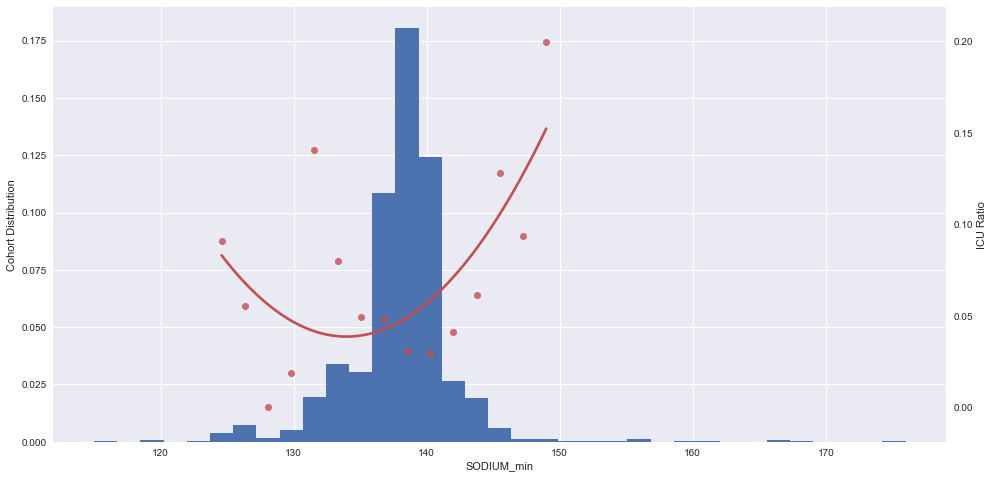

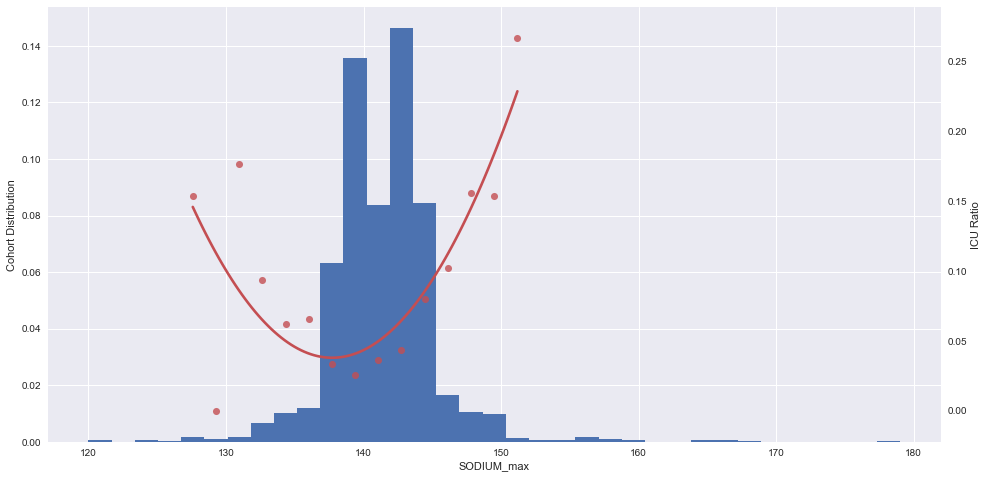

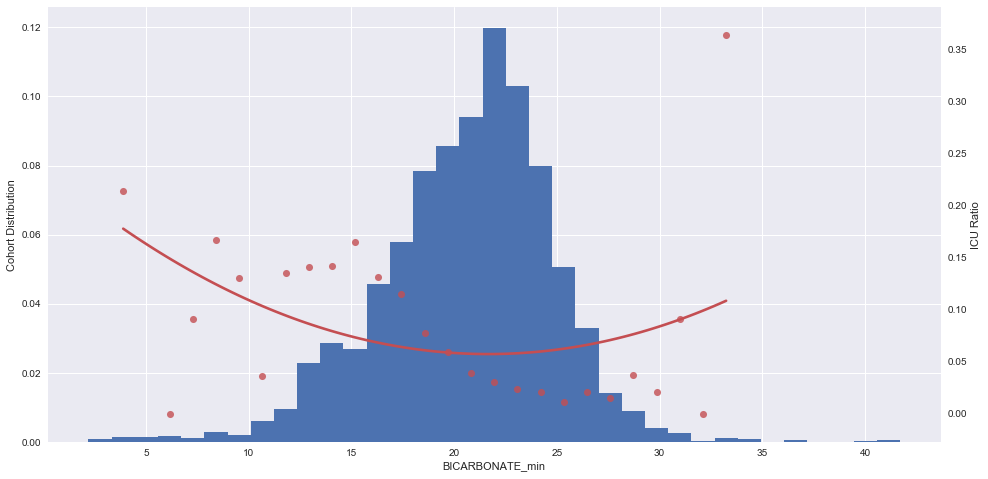

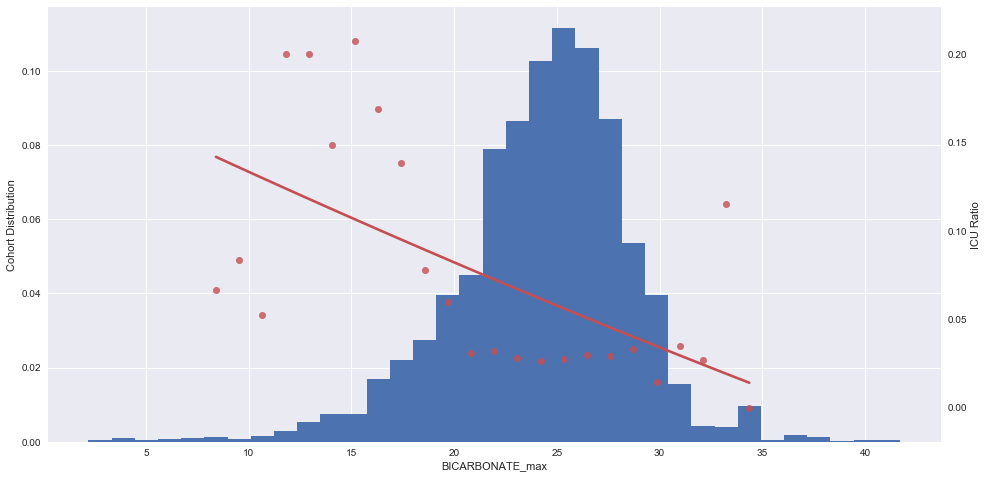

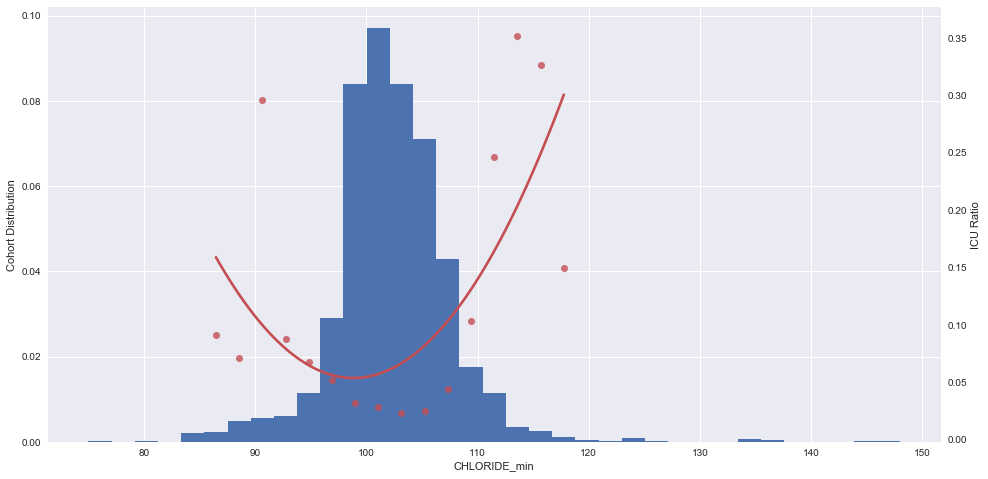

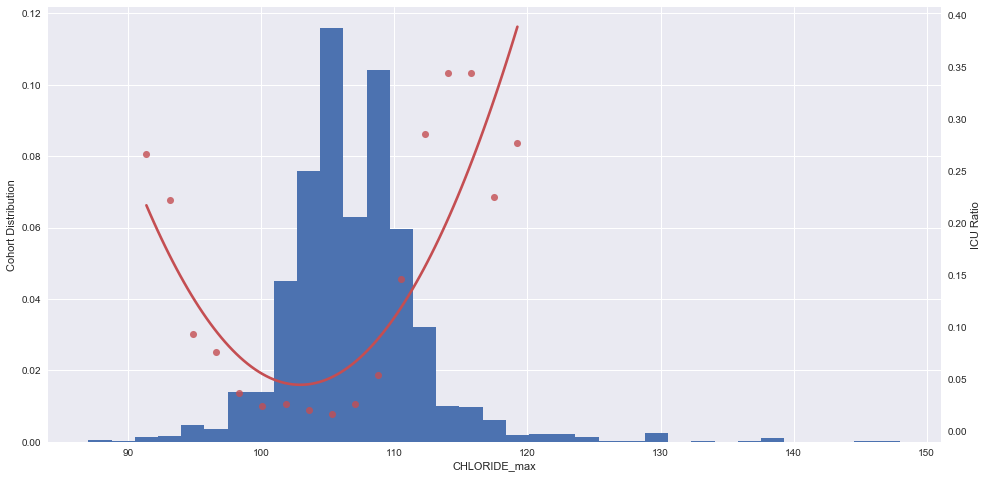

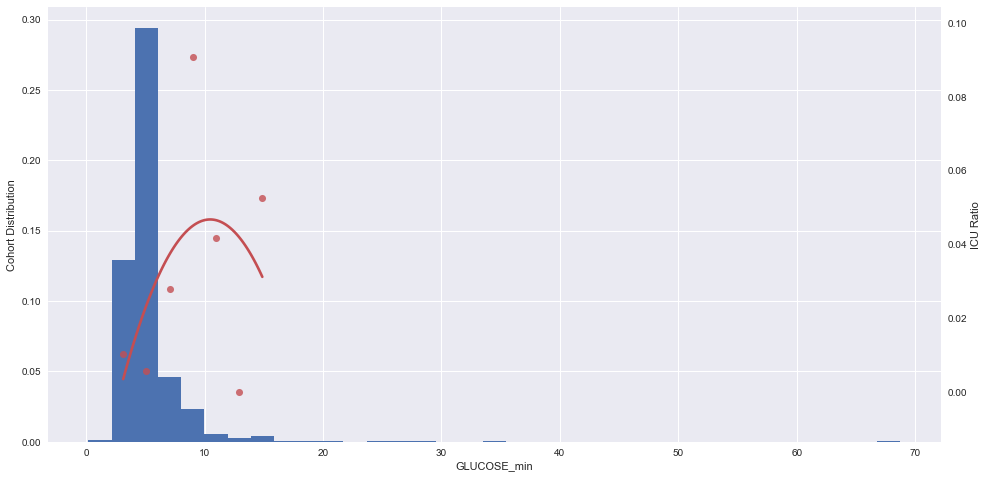

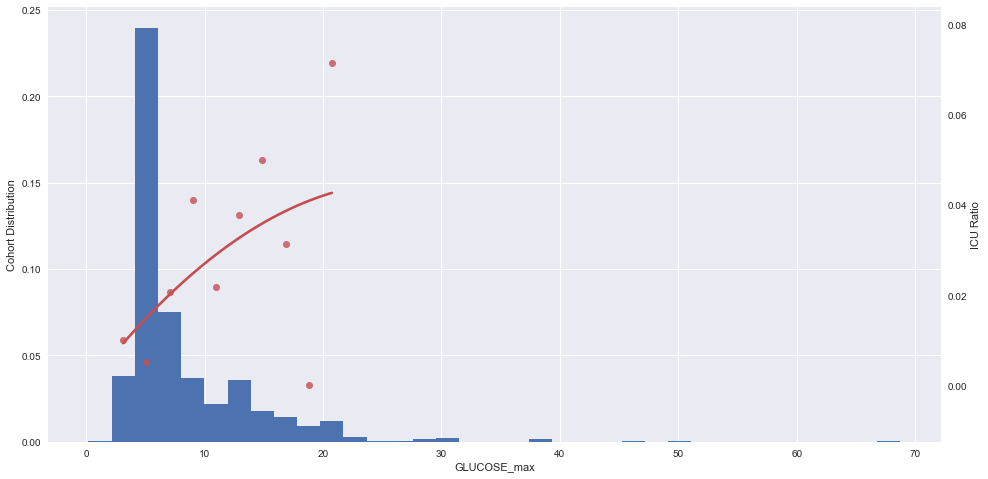

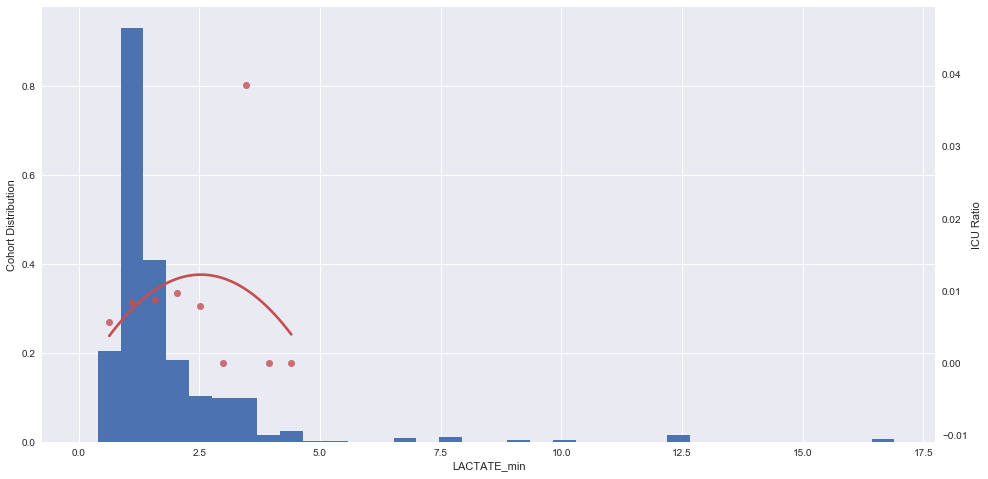

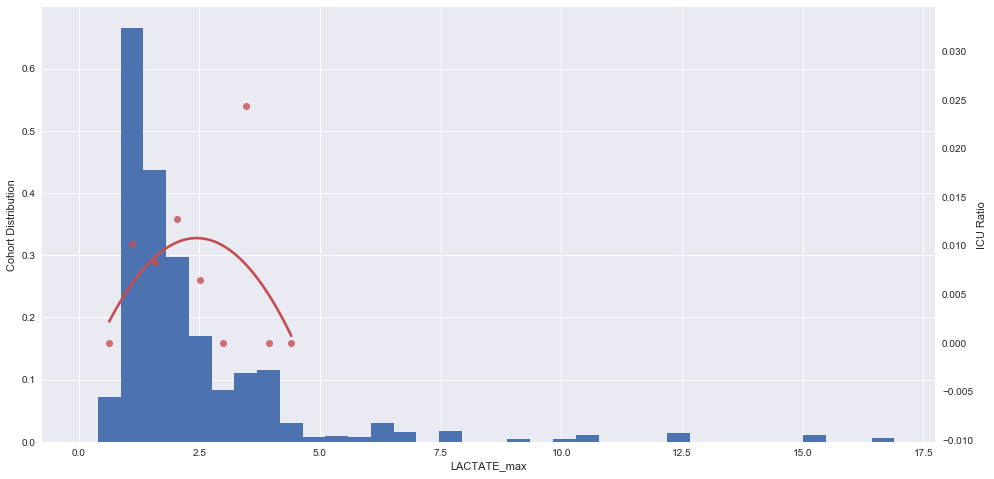

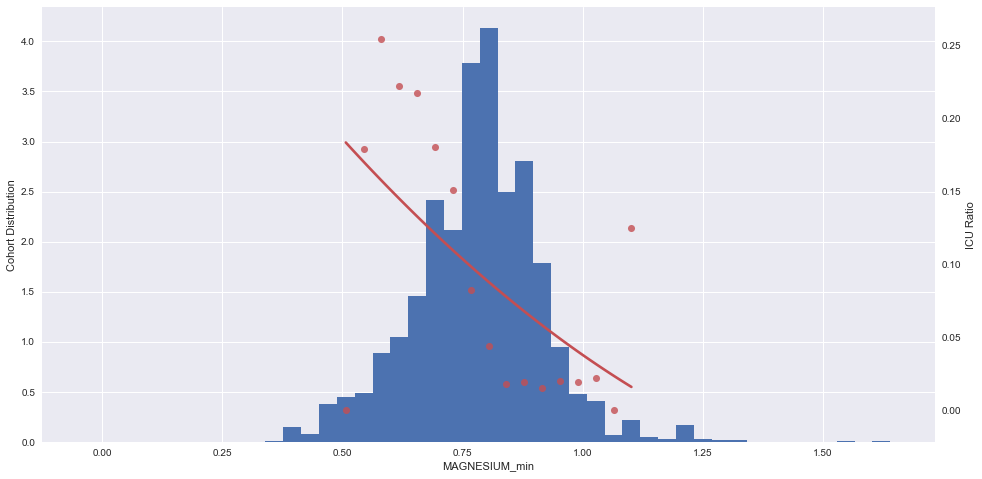

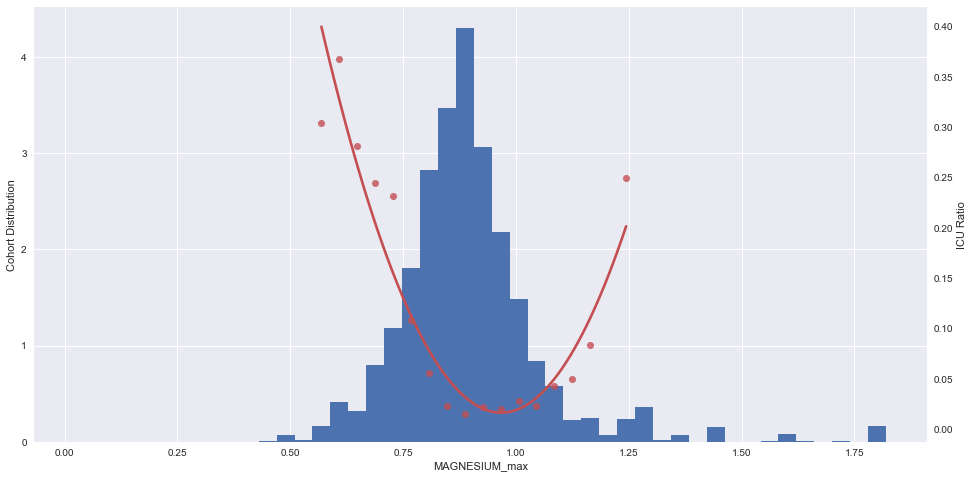

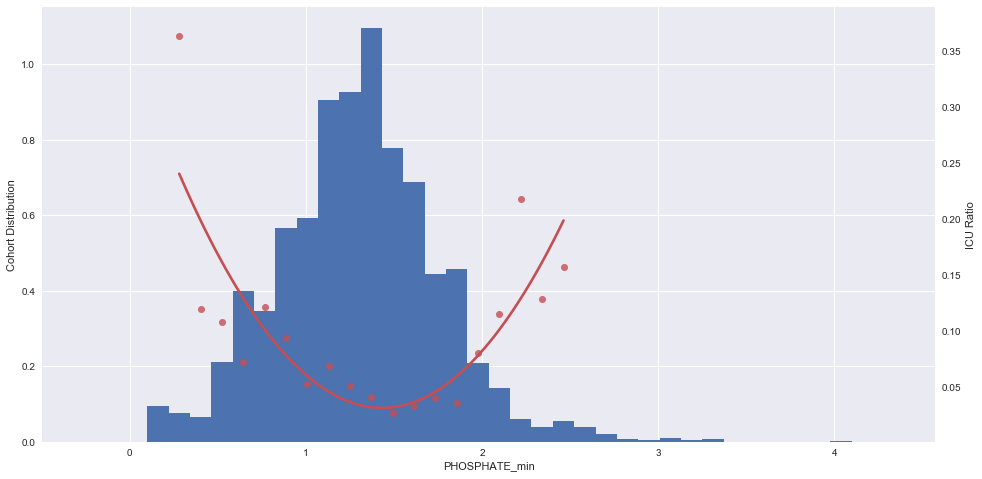

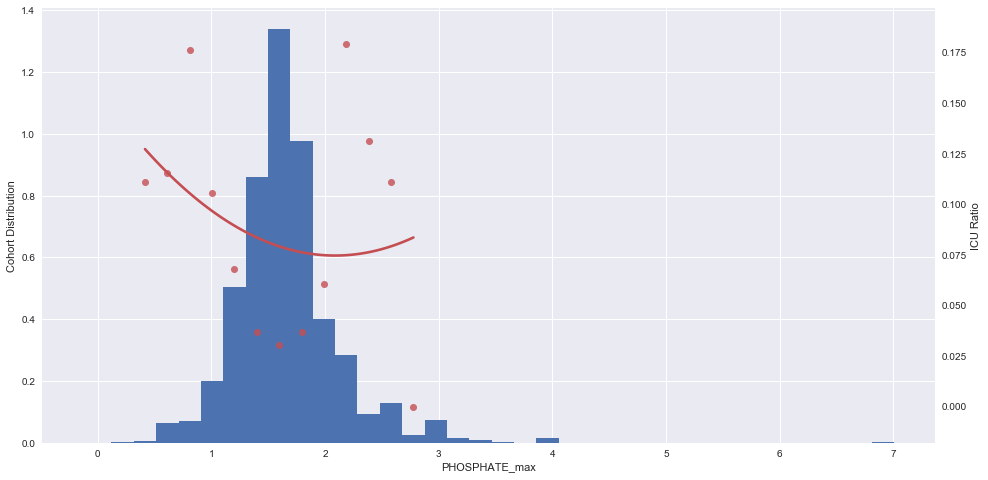

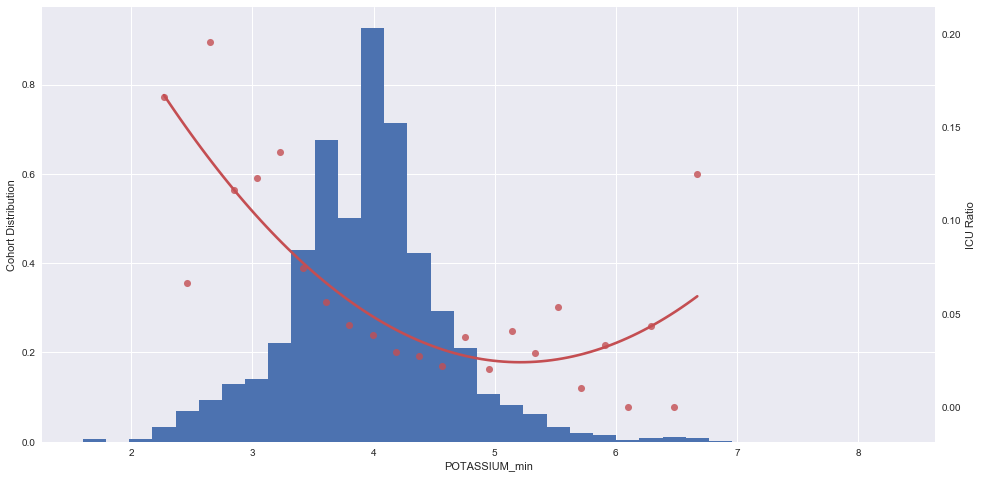

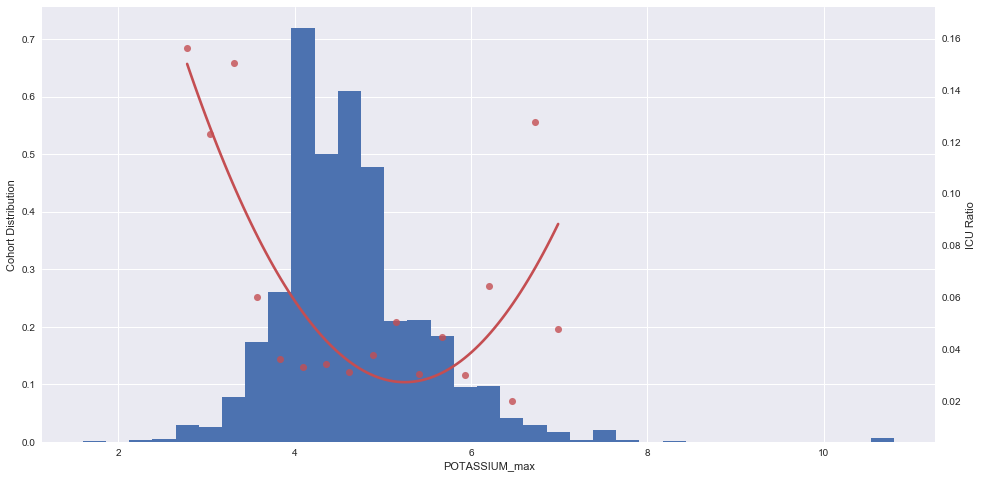

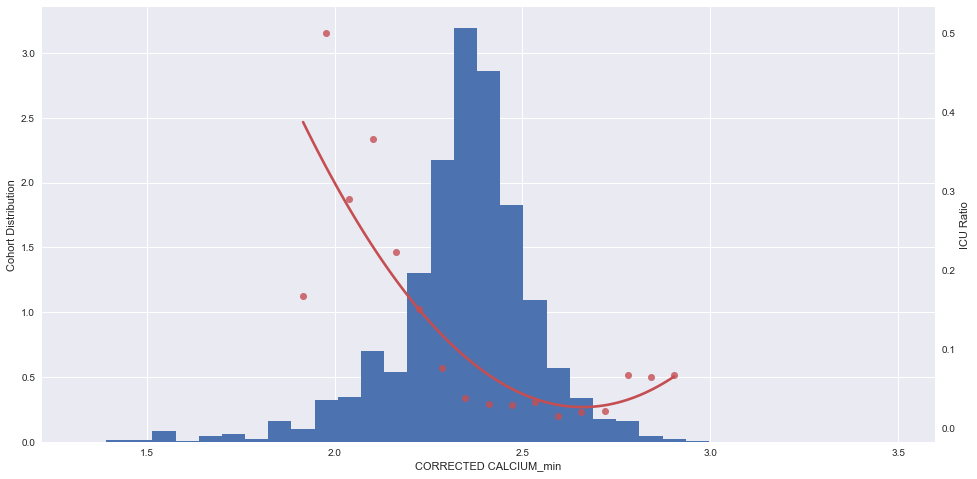

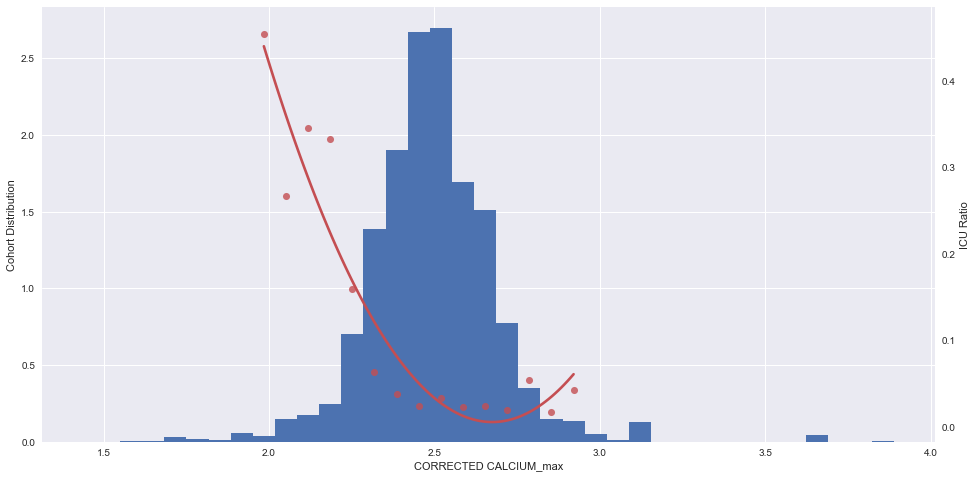

In [10]:
tenth, nintieth = np.percentile(data[lab_value].dropna(), [5, 95])

for lab in lab_minmax:
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(data[lab].dropna(), bins=35, normed=True)
    ax.set_xbound(lower=tenth, upper=nintieth)
    ax.set_xlabel(lab)
    ax.set_ylabel("Cohort Distribution")
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    testar = []
    x = []
    y = []
    for i, reading in enumerate(bins[:-1]):
        criterion = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= bins[i] and x <= bins[i+1]))]
        subjects = data.loc[criterion, 'Research.ID'].unique()
        groups = data[data['Research.ID'].isin(subjects)].groupby('Research.ID')

        if len(subjects) > 10:
            value_count = float(groups.included.agg('max').sum()) / float(len(subjects))
            x.append((bins[i] + bins[i+1]) / 2.0)
            y.append(value_count)

    ax2 = ax.twinx()
    #print(x)
    #print(y)
    #ax2.scatter(x=x, y=y, c='r')
    ax2.grid(False)
    x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
    ax2 = sns.regplot(x=x, y=y,
                      scatter_kws={"s": 50},
                      color='r',
                      order=2, ci=None, truncate=True)
    ax2.set_ylabel("ICU Ratio")

## Task 3.a : Min/Max probability plot

for lab value i in 5 percentile to 95 percentile: 
$$
    P(y=1|x=i) = \frac{P(x=i|y=1) \cdot P(y=1)}{P(x=i)}
$$

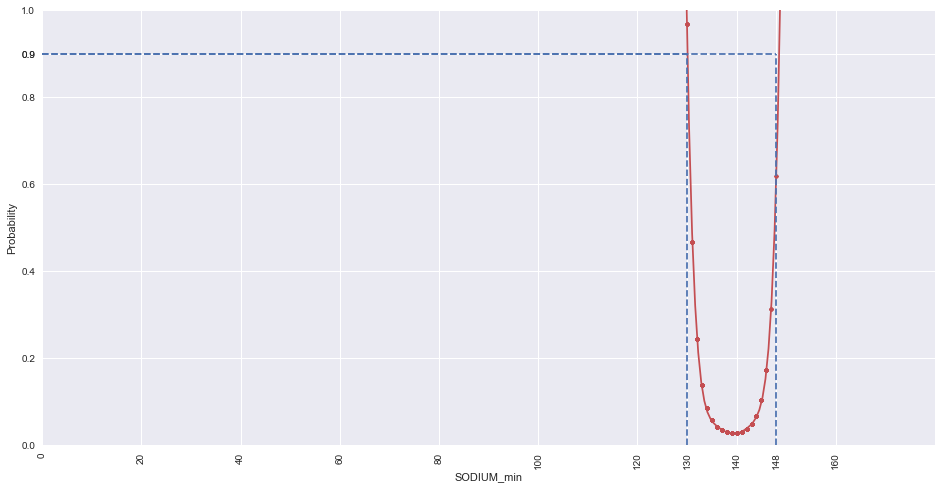

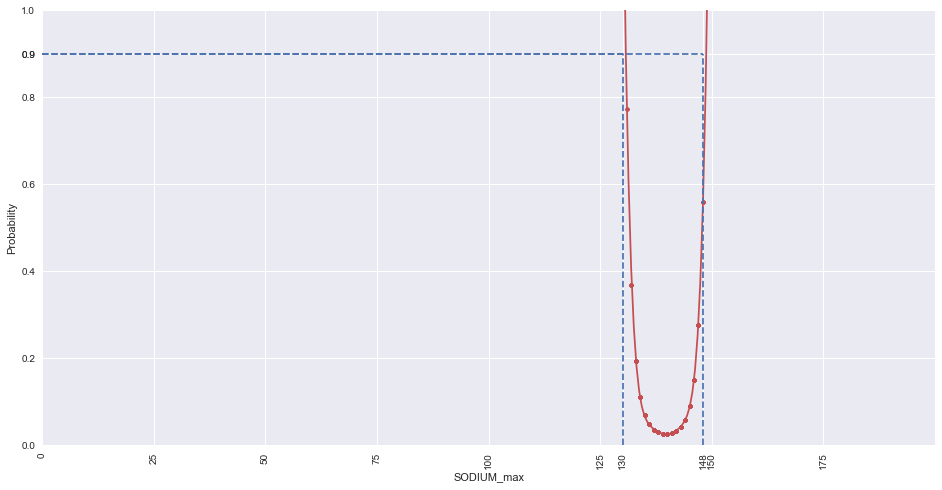

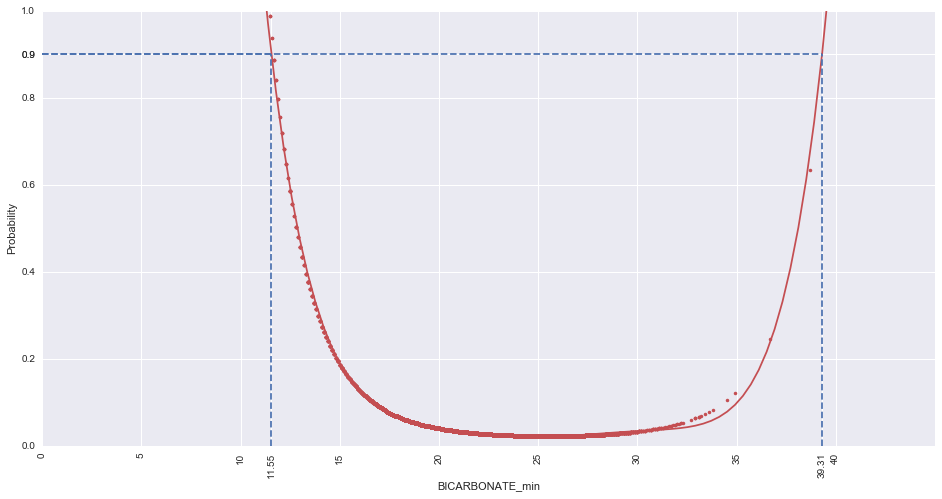

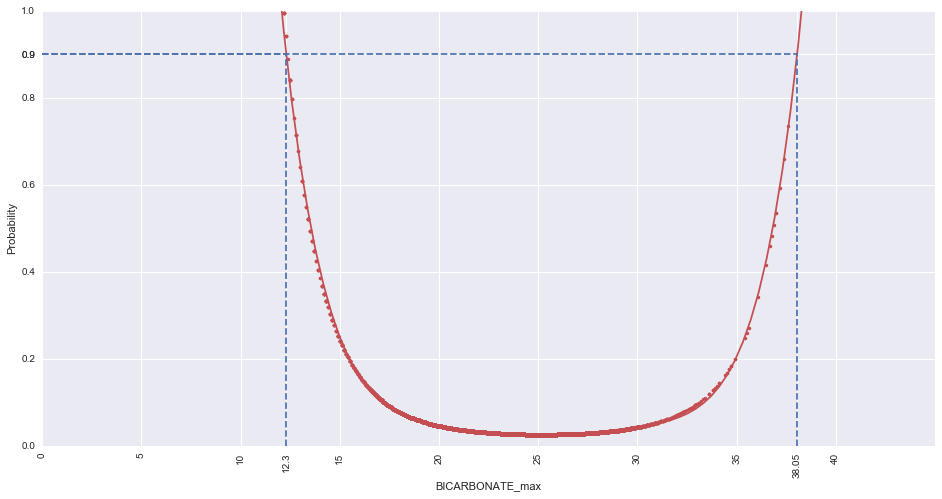

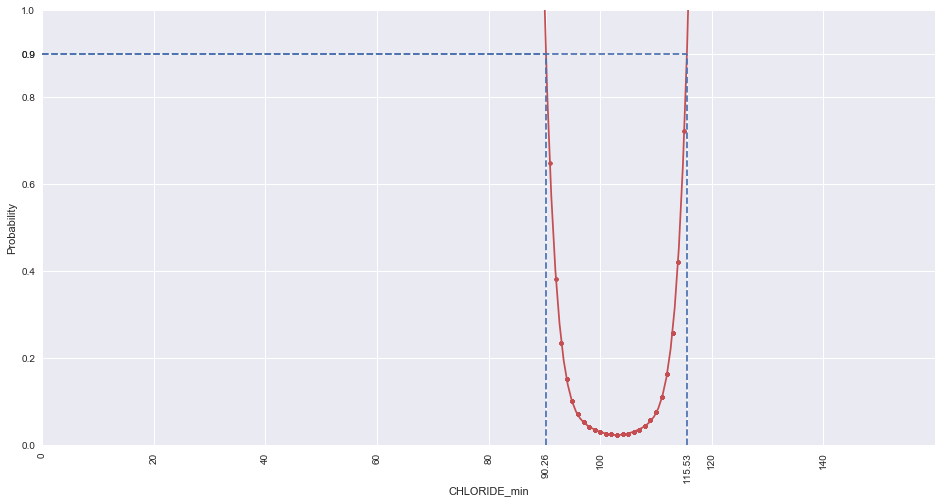

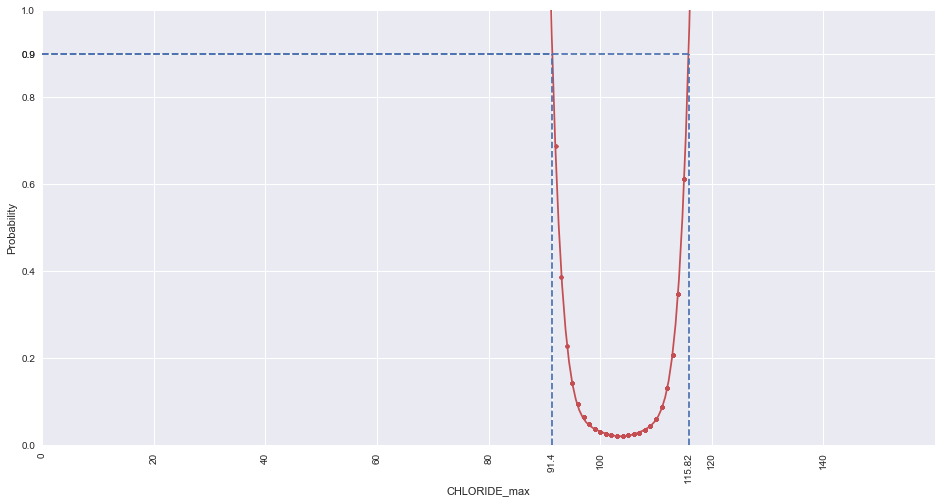

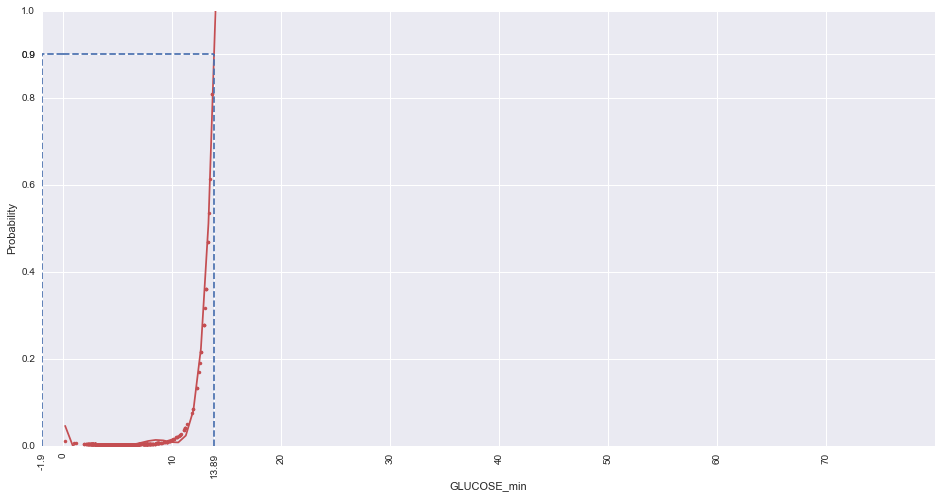

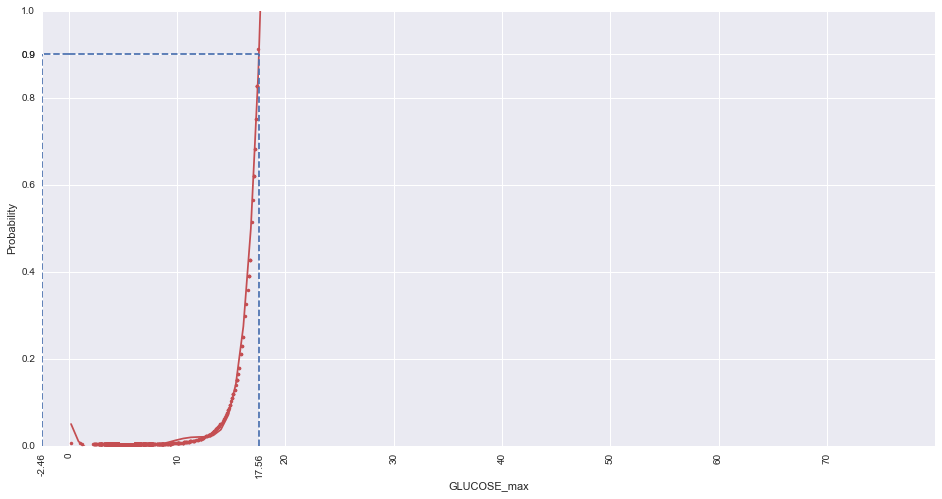

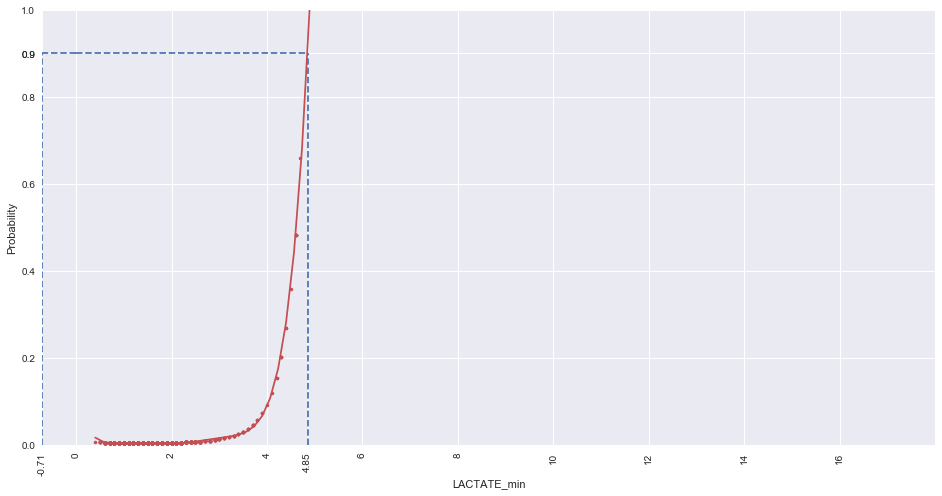

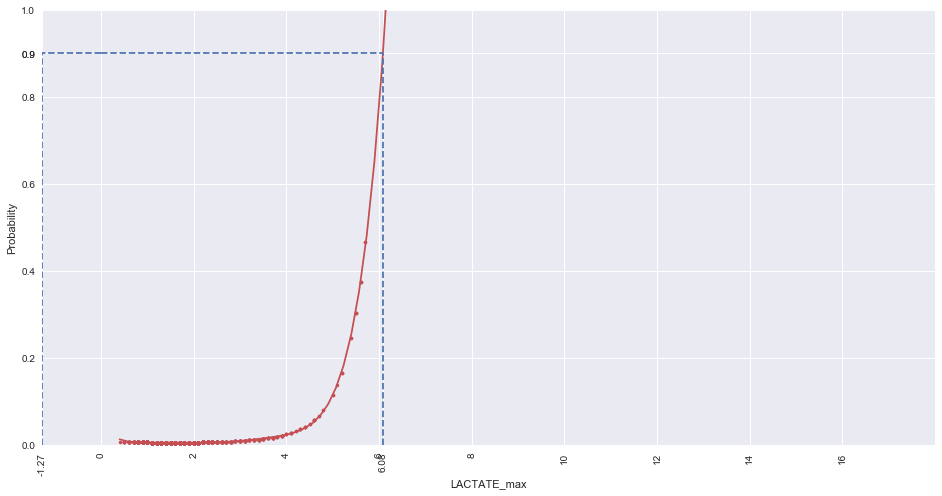

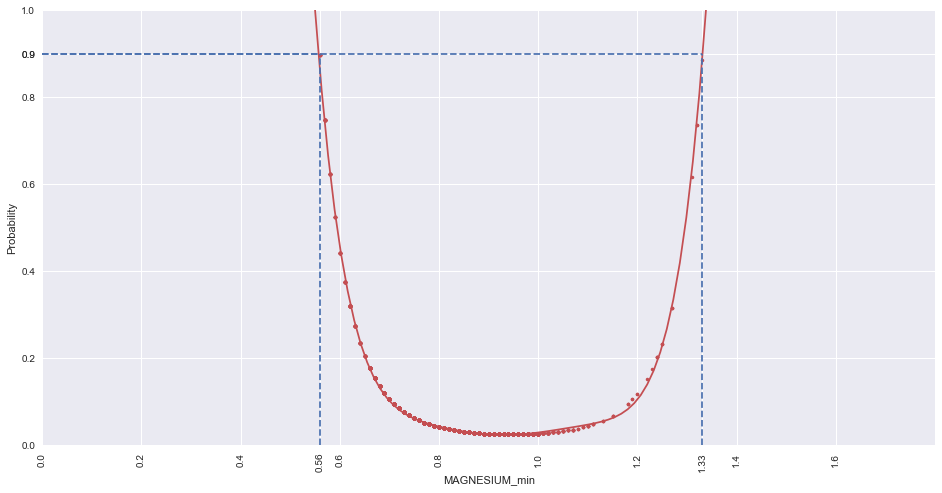

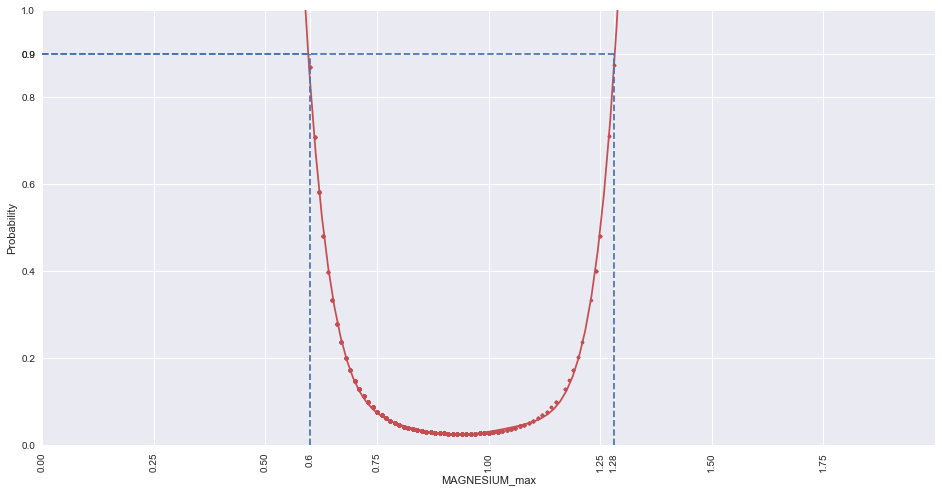

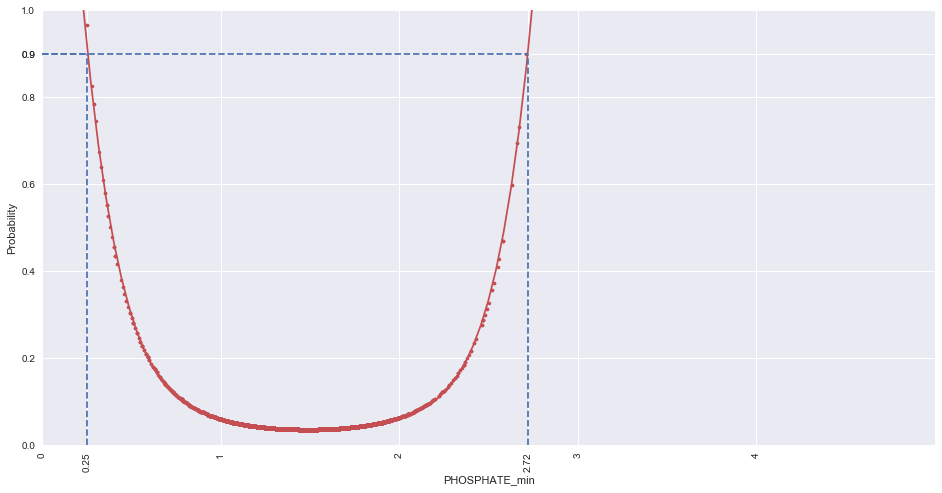

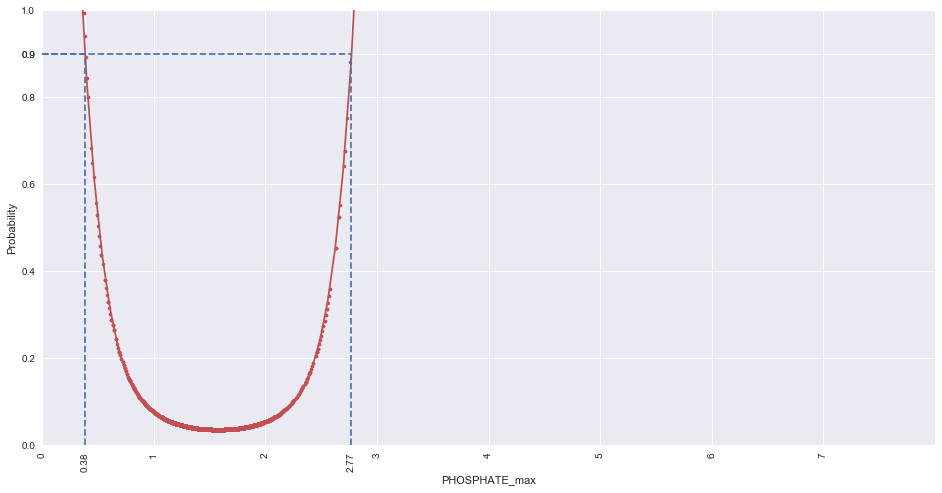

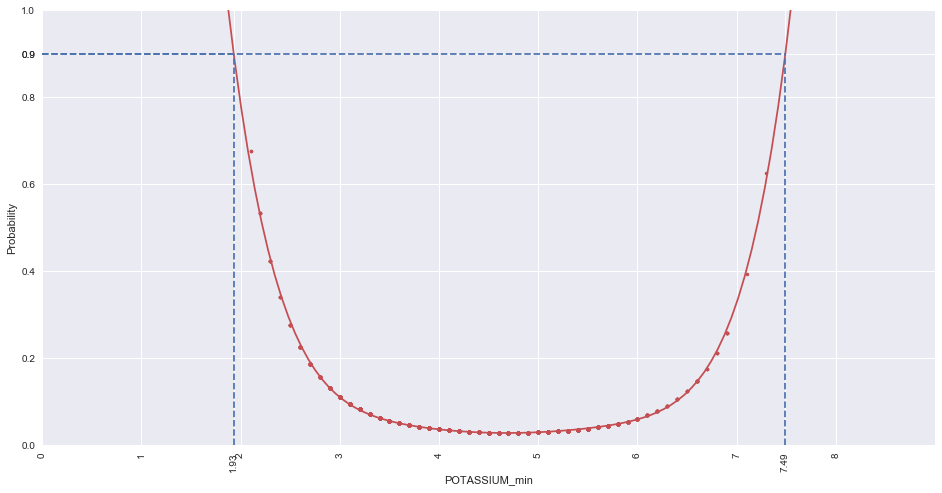

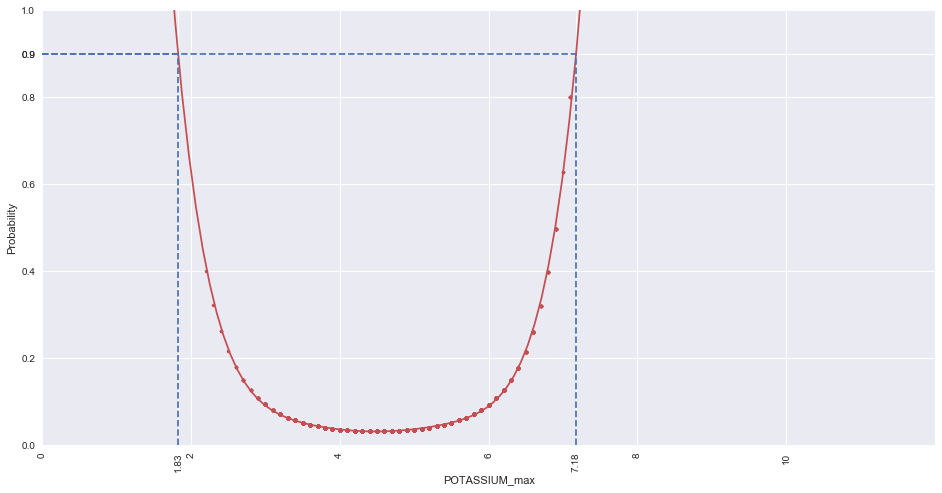

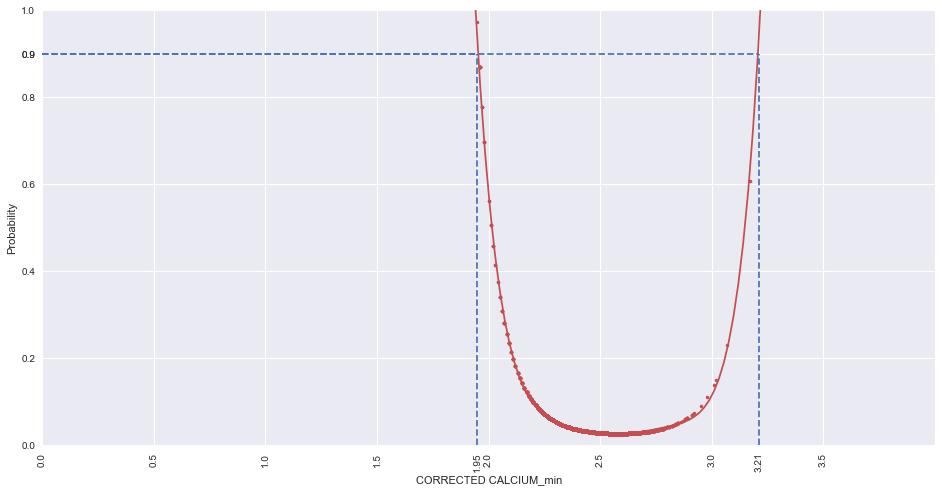

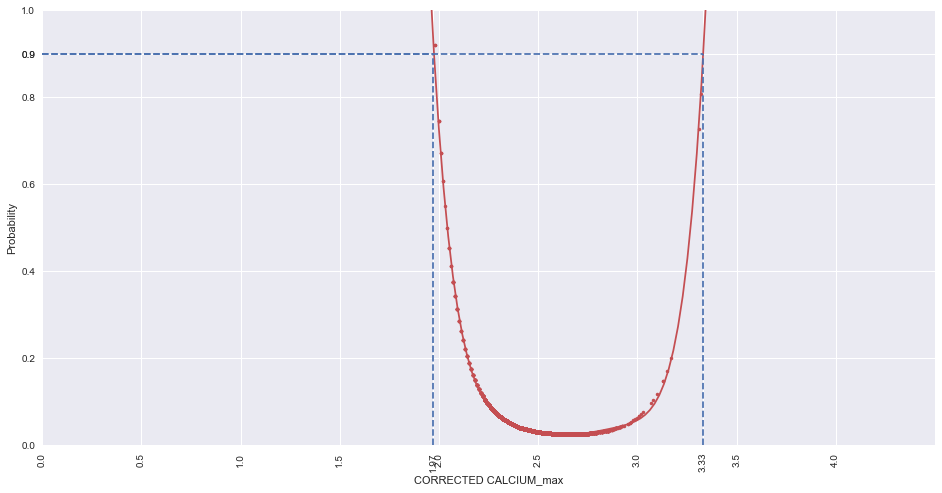

In [23]:
for lab in lab_minmax:
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    _max, _min = np.max(data[lab]), np.min(data[lab])
    fig, ax = plt.subplots()
    
    
    _crit = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)))]
    _subjects = data.loc[_crit, 'Research.ID'].unique()
    _group = data[data['Research.ID'].isin(_subjects)].groupby('Research.ID')
    
    X = _group[lab].agg('max').as_matrix()
    y = _group['included'].agg('max').astype(int).as_matrix()
    
    #bins = np.arange(tenth, nintieth)
    bins = np.linspace(tenth, nintieth, 10)
    _x = []
    _y = []

    p_y_1 = y.sum() / y.shape[0]
    #p_y_1 = 763.0 / 25309.0
    x_mean = np.mean(X)
    x_std = np.std(X)
    x_norm = scipy.stats.norm(x_mean, x_std)
    
    pos_crit = [i and j and z for i, j, z in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)), 
                                                 data['included'])]
    pos_subjects = data.loc[pos_crit, 'Research.ID'].unique()
    pos_group = data[data['Research.ID'].isin(pos_subjects)].groupby('Research.ID')
    X_pos = pos_group[lab].agg('max').as_matrix()
    y_pos = pos_group['included'].agg('max').astype(int).as_matrix()
    X_pos_mean = np.mean(X_pos)
    X_pos_std = np.std(X_pos)
    X_pos_norm = scipy.stats.norm(X_pos_mean, X_pos_std)
    #print(bins)
    for i in X:
        _p = (X_pos_norm.pdf(i) * p_y_1) / x_norm.pdf(i)
        #if _p > 1:
        #print(X_pos_norm.pdf(i))
        #print(x_norm.pdf(i))
        #print(_p)
        if _p < 1.0 and _p > 0:
            _x.append(i)
            _y.append(_p)
    ax.scatter(x=_x, y=_y, c='r', s=2)

    p = P.fit(_x, _y, 6)
    roots = (p-.9).roots()
    x_plots = [i.real for i in roots if i.imag == 0]
    #if lab[:6]=='SODIUM':
    #    x_plots = x_plots[:2]
    #if len(x_plots) > 2:
    #    x_plots = [i for i in x_plots if i < nintieth]
    xp = np.linspace(_min, _max, 100)
    
    plt.plot(_x, _y, '.', xp, p(xp), '-', color='r')
    plt.ylim(0, 1)
    plt.xlim(0)
    
    plt.draw()
    labels = [ i.get_text() for i in ax.get_xticklabels()]
    locs=list(ax.get_xticks())
    ylabels = [ i.get_text() for i in ax.get_yticklabels()]
    ylocs=list(ax.get_yticks())
    
    for x_plot in x_plots:
        if lab[:6]=='SODIUM': 
            x_plot = int(x_plot)
        else:
            x_plot = round(x_plot, 2)
        labels.append(x_plot)
        locs.append(x_plot)
        ylabels.append(0.9)
        ylocs.append(0.9)
        plt.plot((0, x_plot), (.9, .9), 'b-', linestyle='--')
        plt.plot((x_plot, x_plot), (0, .9), 'b-', linestyle='--')
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xticks(locs)
    ax.set_yticklabels(ylabels)
    ax.set_yticks(ylocs)
   
    
    #ax.set_xbound(lower=_min, upper=_max)
    #ax.set_ylim(1.0)
    ax.set_xlabel(lab)
    ax.set_ylabel("Probability")

## Task 3.b : Min/Max probability plot (Log-logistic Regression)

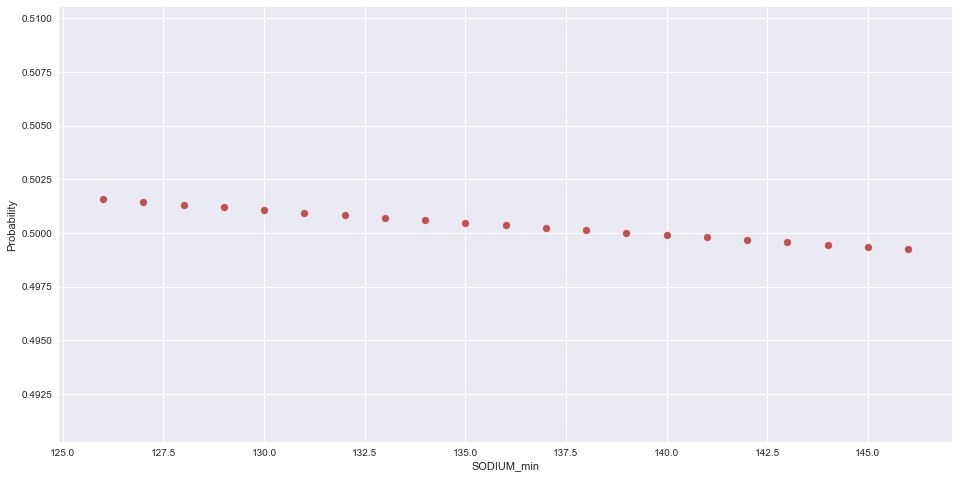

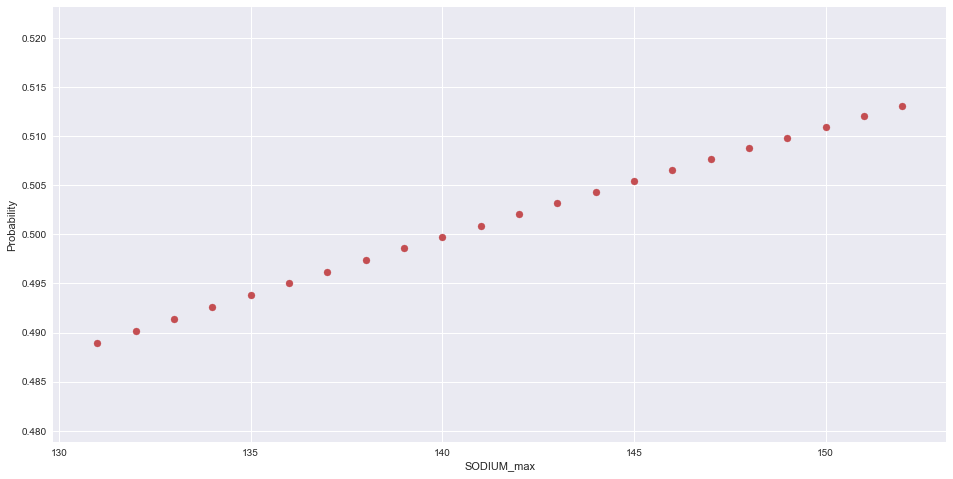

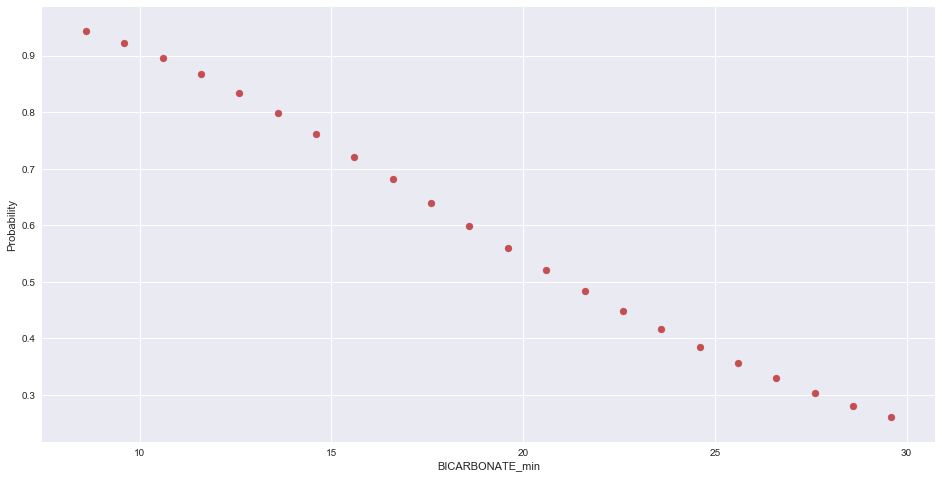

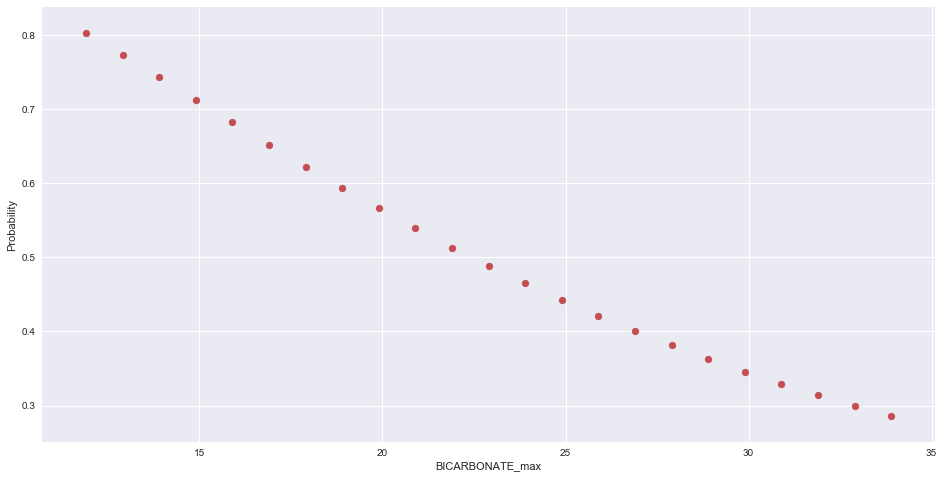

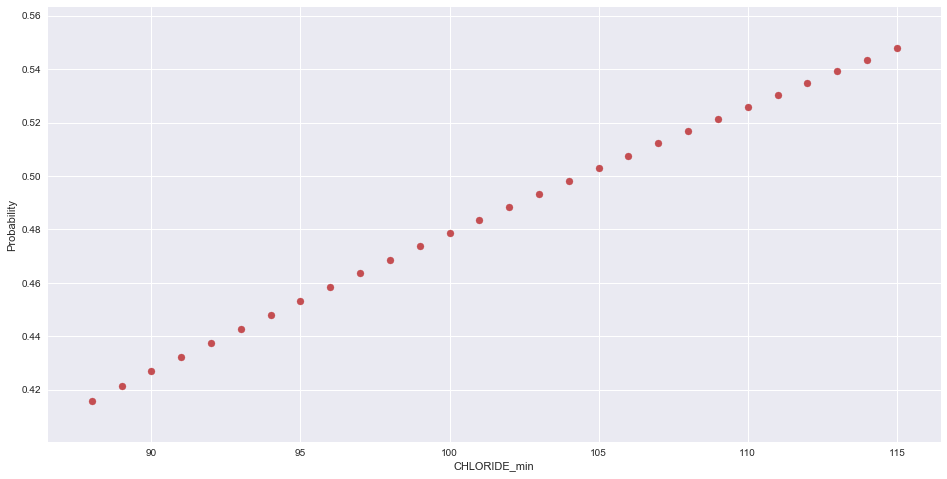

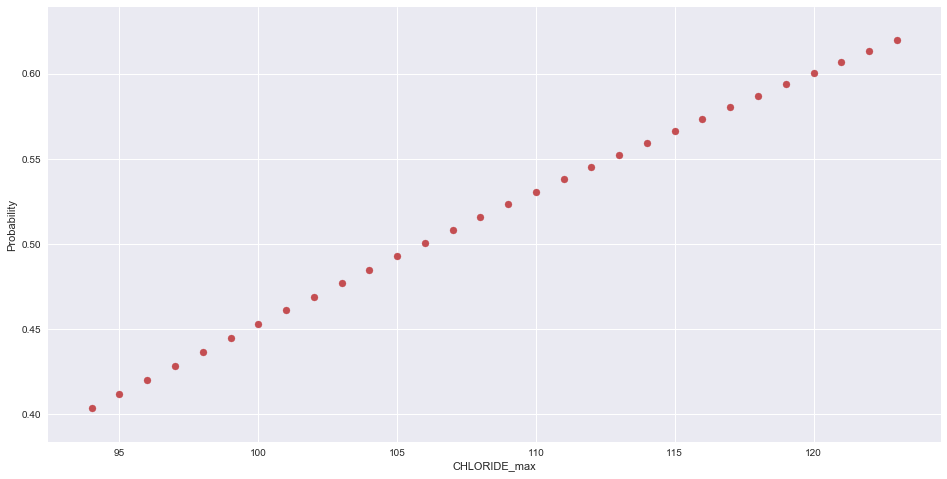

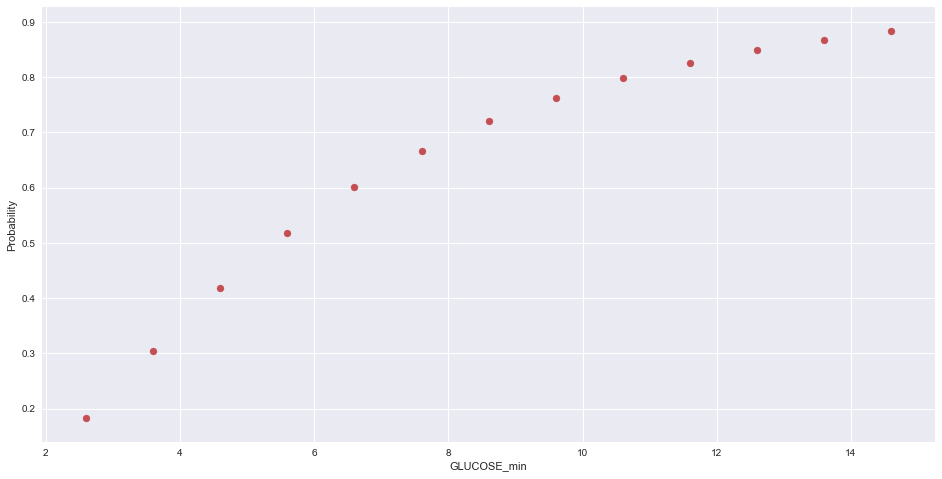

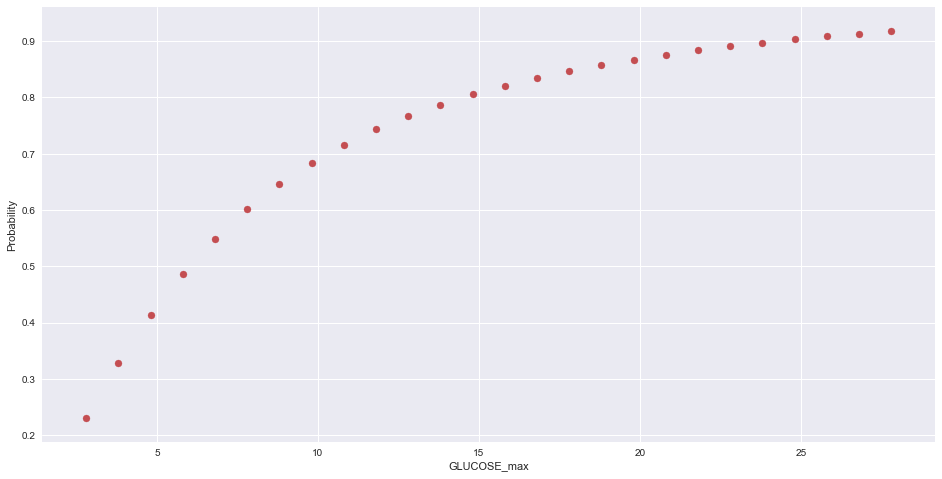

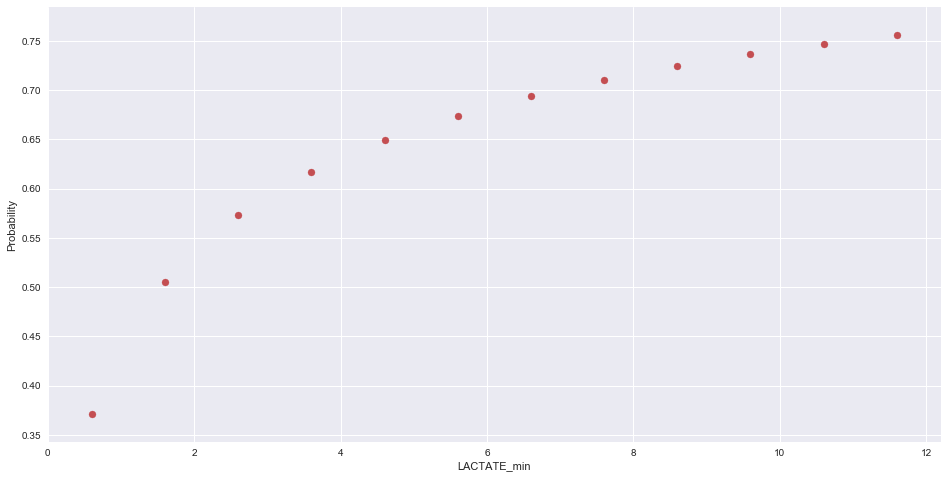

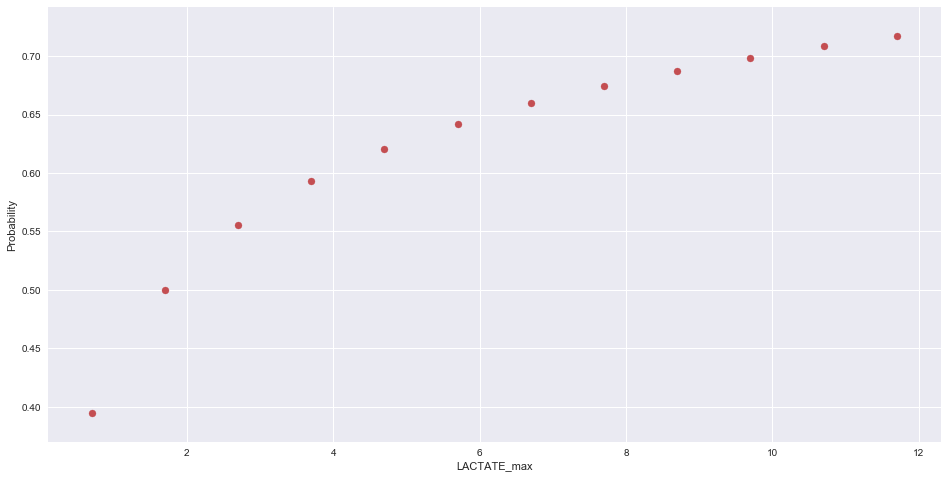

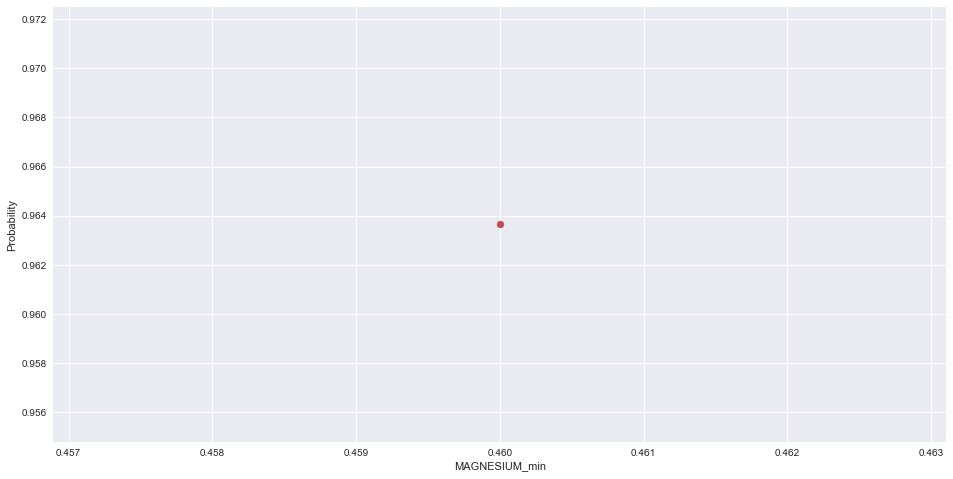

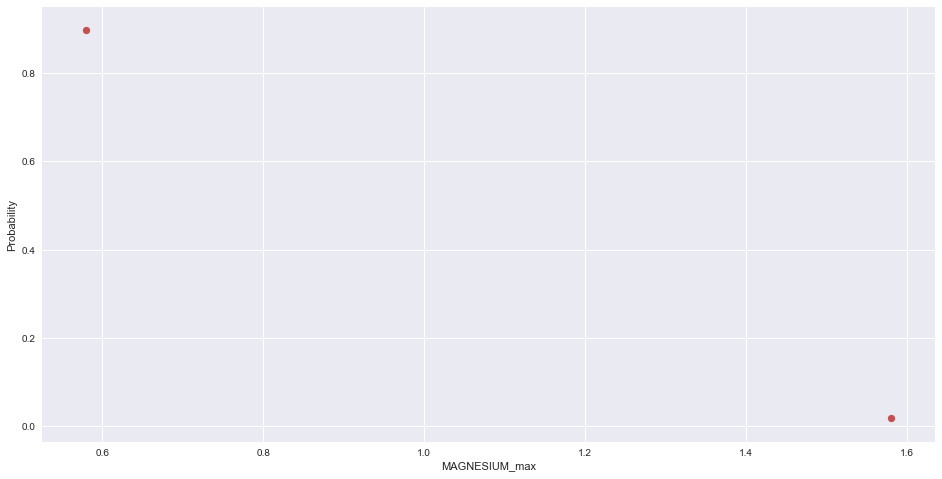

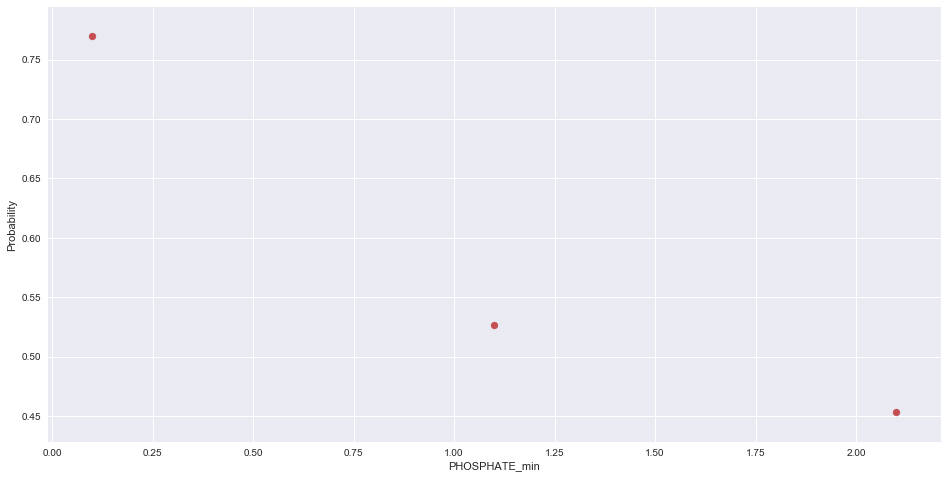

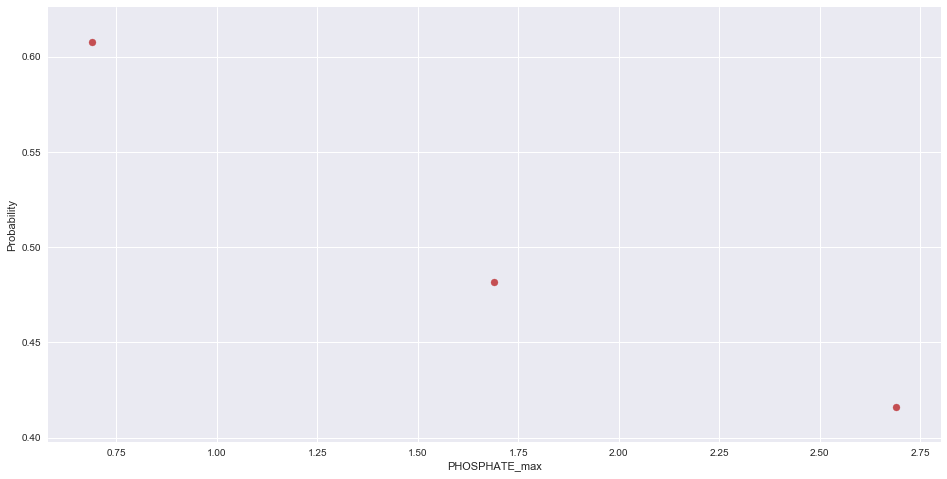

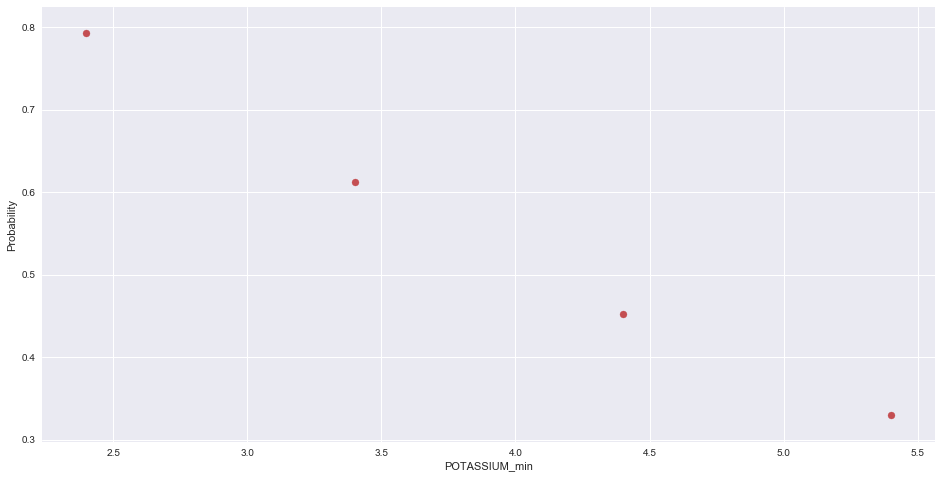

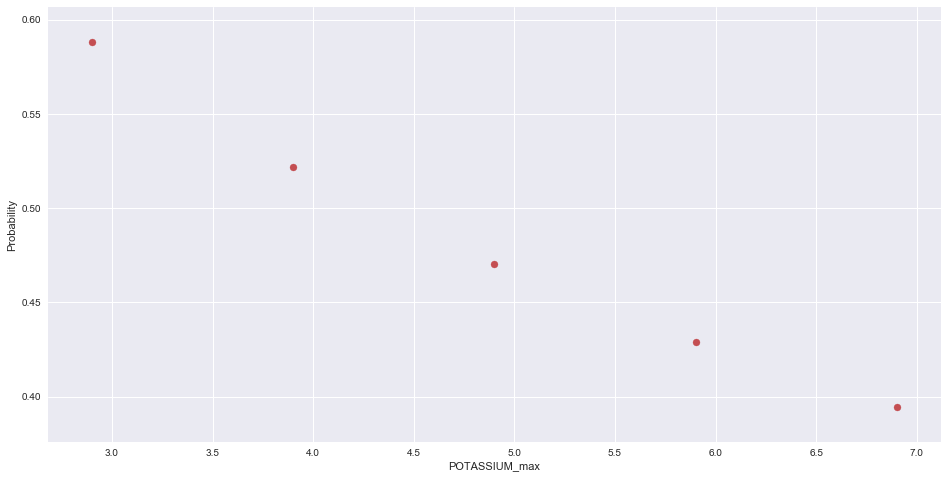

In [73]:
for lab in lab_minmax:
    clf = LogisticRegression(class_weight='balanced')
    
    tenth, nintieth = np.percentile(data[lab].dropna(), [1, 99])
    _crit = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)))]
    _subjects = data.loc[_crit, 'Research.ID'].unique()
    _group = data[data['Research.ID'].isin(_subjects)].groupby('Research.ID')
    
    X = _group[lab].agg('max').as_matrix().reshape(-1, 1)
    #print(X)
    X = np.log(X)
    #print(X)
    y = _group['included'].agg('max').astype(int).as_matrix()
    #print(y.shape)
    clf.fit(X=X, y=y)
    
    fig, ax = plt.subplots()
    ax.set_xbound(lower=tenth, upper=nintieth)
    ax.set_xlabel(lab)
    ax.set_ylabel("Probability")
    # bins = np.linspace(tenth, nintieth, num=30)
    bins = np.arange(tenth, nintieth)
    _x = []
    _y = []
    
    for i in bins:
        #print(np.log(i))
        _prob = clf.predict_proba(X=np.array(np.log([i])).reshape(-1,1))
        #print(clf.classes_)
        #print(_prob)
        _x.append(i)
        #print(_prob[0][1])
        _y.append(_prob[0][1])
    ax.scatter(x=_x, y=_y, c='r')
    #print(_x)
    #print(_y)
    #_x, _y = pd.Series(_x[:], name=""), pd.Series(_y[:], name="")
    #ax = sns.regplot(x=_x, y=_y,
    #                  scatter_kws={"s": 50},
    #                  color='r',
    #                  order=3, ci=None, truncate=False)

## Task 4: Cumulative frequency plot

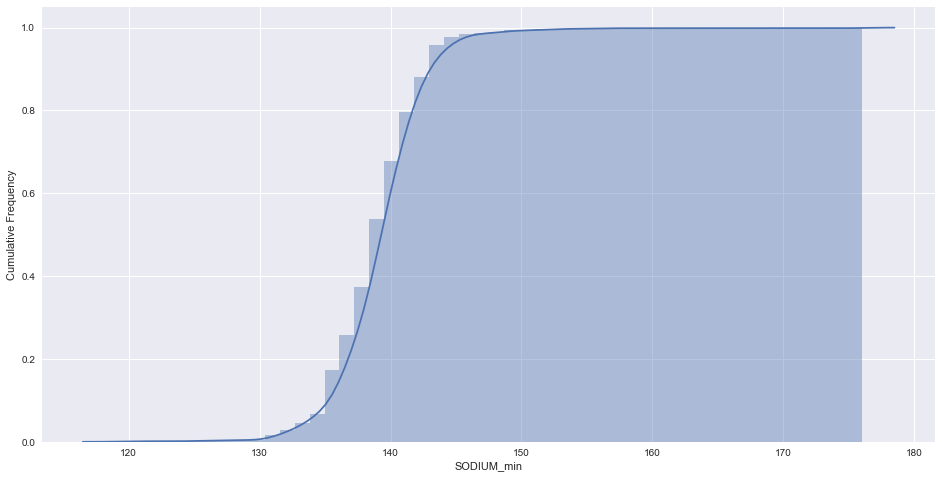

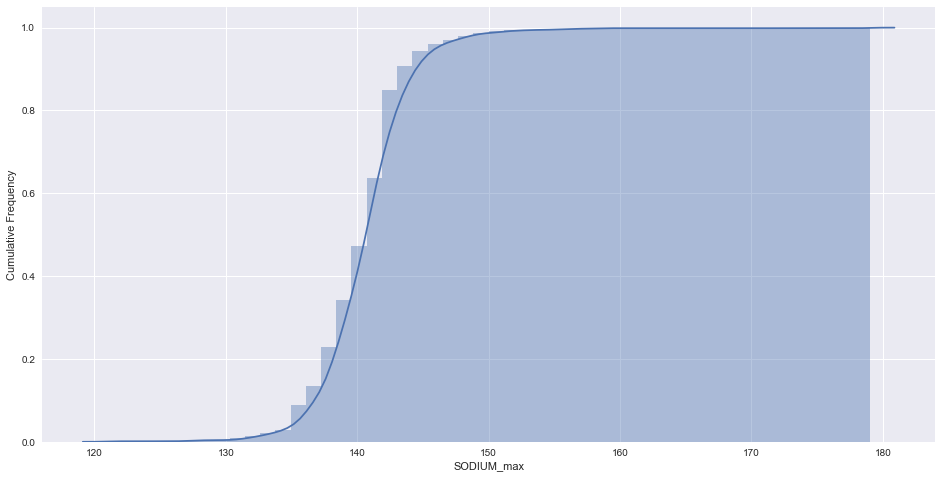

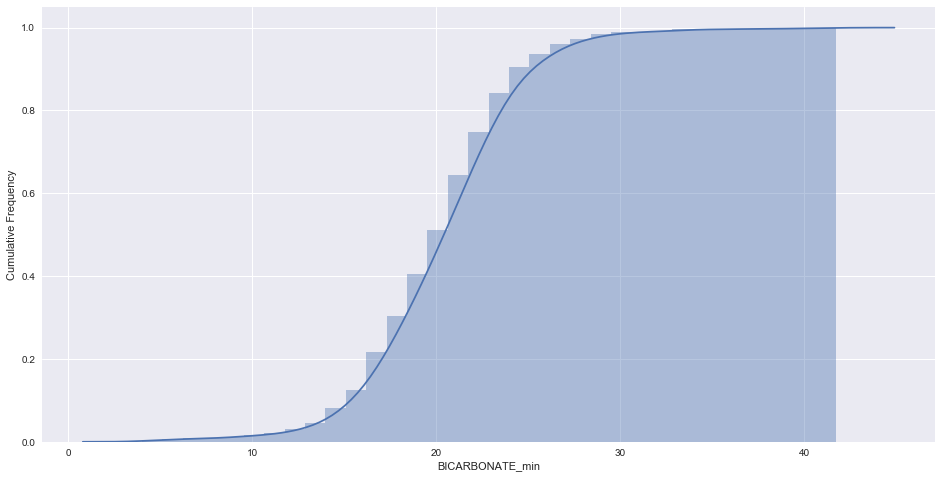

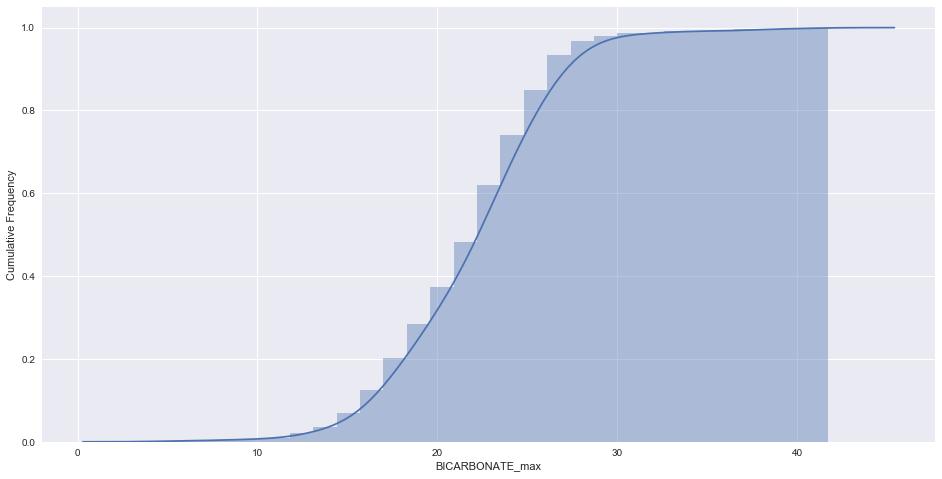

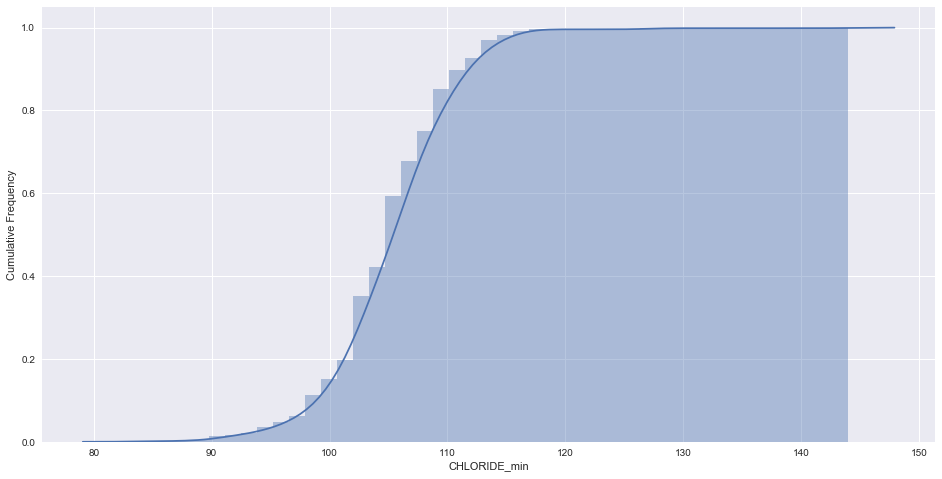

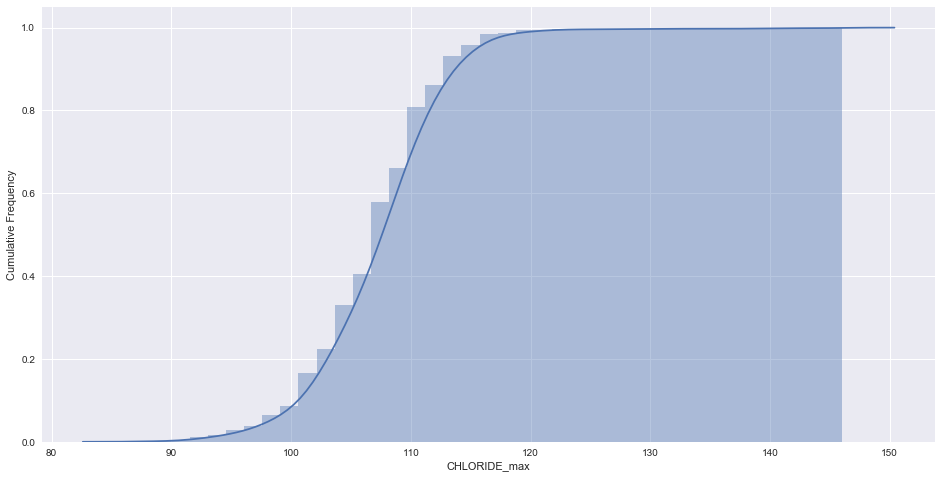

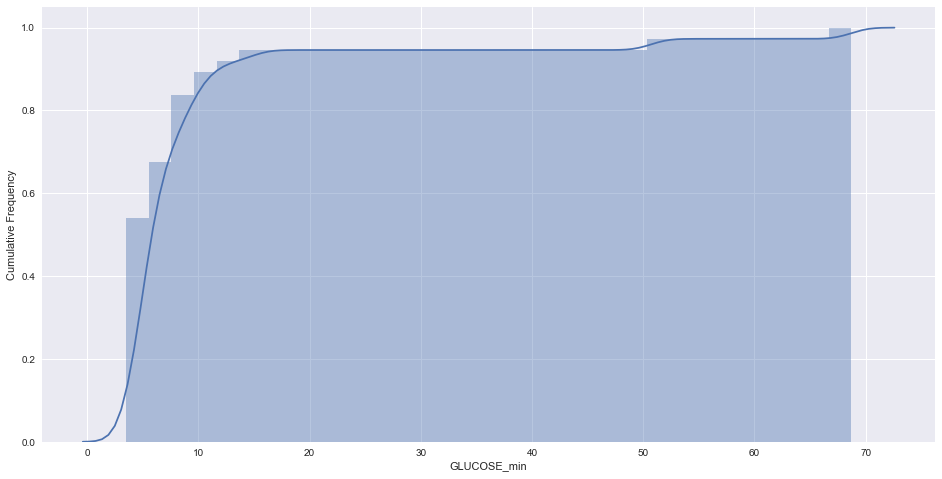

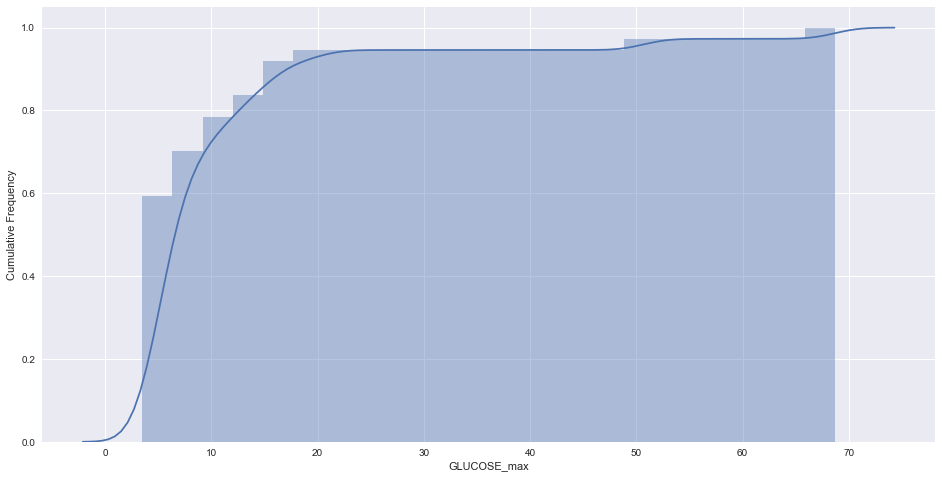

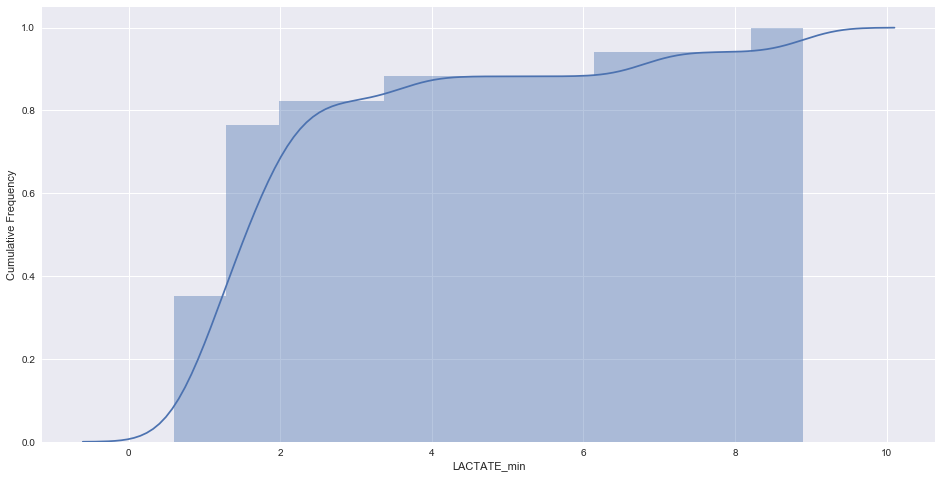

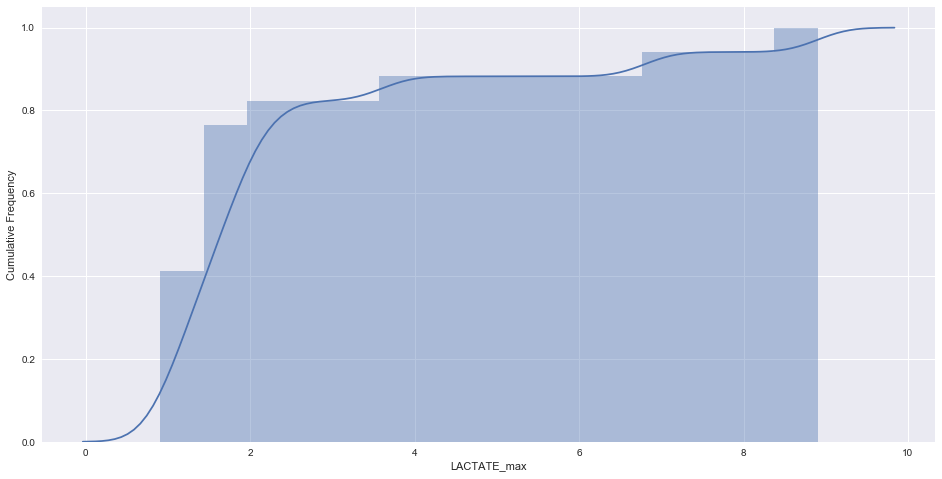

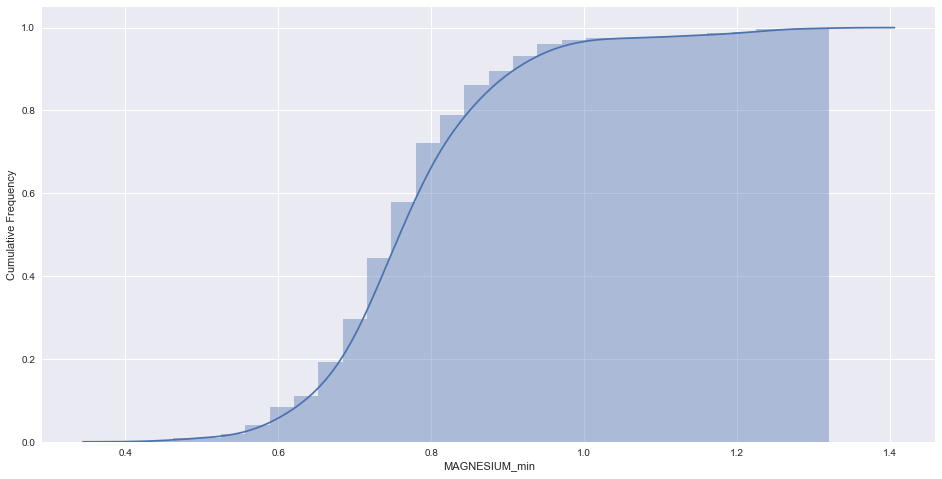

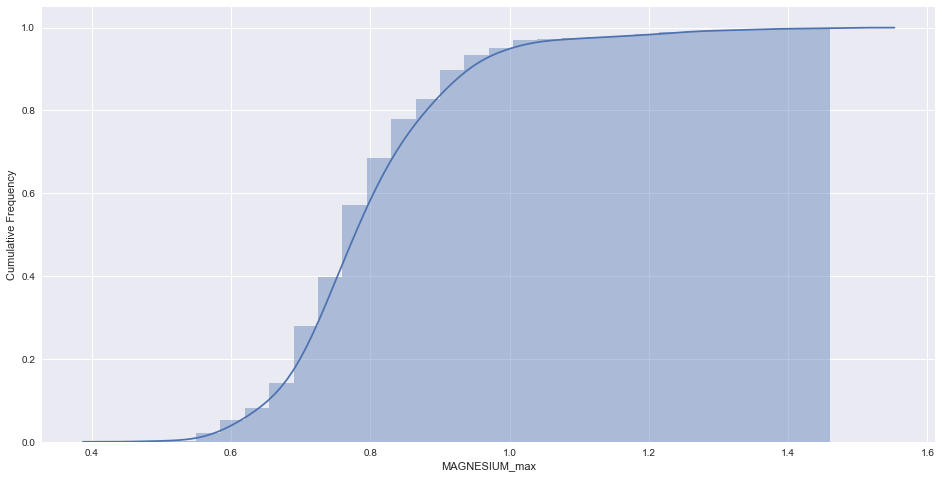

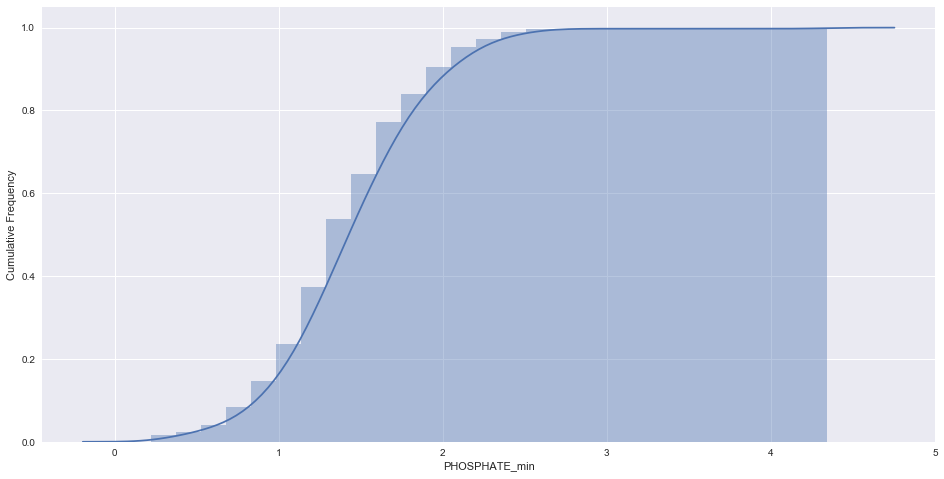

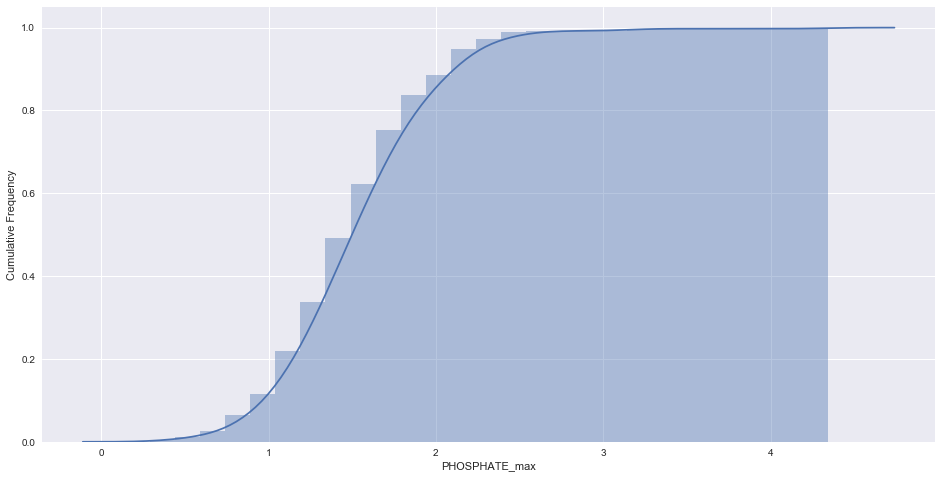

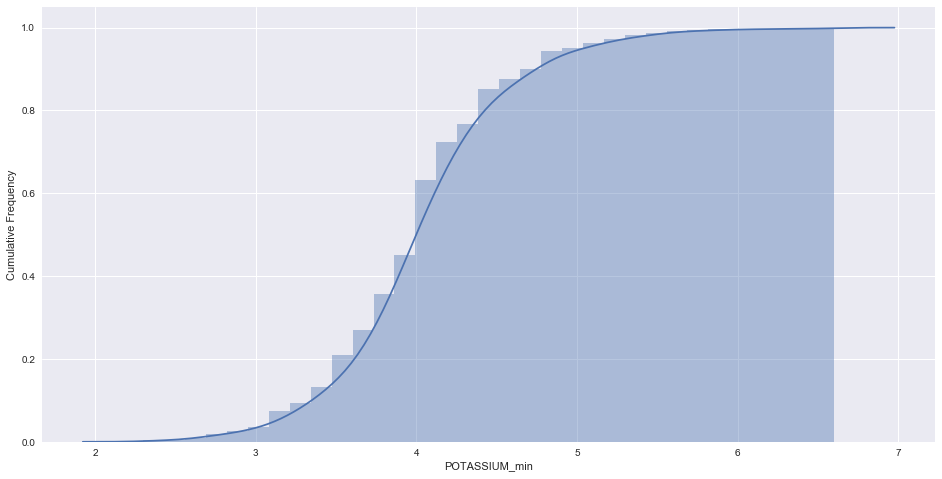

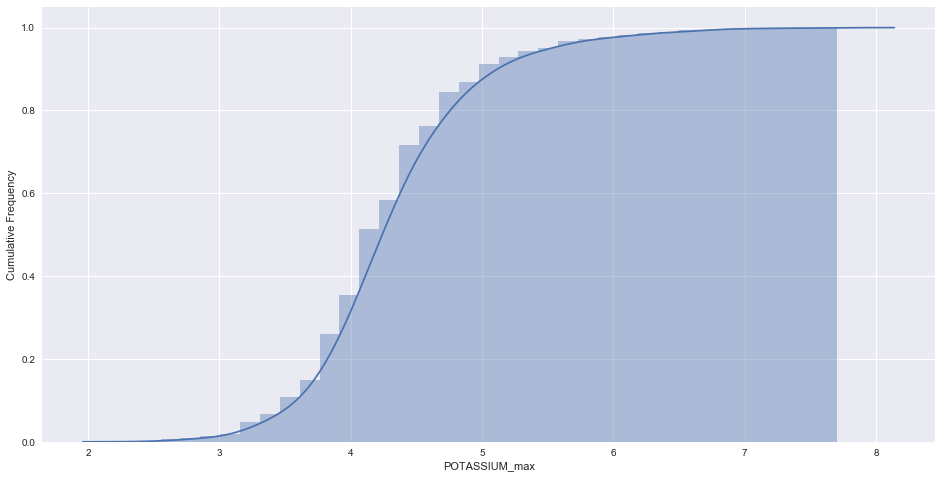

In [74]:
for lab in lab_minmax:
    fig, ax = plt.subplots()
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
    crit_x = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x)))]
    subjects = data.loc[crit_x, 'Research.ID'].unique()
    x = []
    y = []
    for i in subjects:
        temp = np.max(data.loc[data['Research.ID']==i, lab])
        x.append(temp)
        
        temp_y = np.max(data.loc[data['Research.ID']==i, 'included'])
        y.append(temp_y)
    #print(x[:100])
    #print(y[:100])

    sns.distplot(x,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
    ax.set_xlabel(lab)
    ax.set_ylabel("Cumulative Frequency")

## (_* Removed *_) Task 3: Min / Max odds ratio plot 

Plot ICU odds ratio

Cohort (age < 18) for value range x: (when x < 140)

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value <= x    | a                           | b                            |   |   |
| Max/Min value > x | c                           | d                            |   |   |

when x >= 140 

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value >= x    | a                           | b                            |   |   |
| Max/Min value < x | c                           | d                            |   |   |


Odds Ratio (OR) = (a/b) / (c/d) = (a × d) / (b × c)




In [ ]:
# teenagers = data.loc[data.age < 18.0, 'Research.ID'].unique()
# OR_cohort = data[data['Research.ID'].isin(teenagers)].copy()
# print(len(teenagers))

In [ ]:
# for lab in lab_minmax:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
#     for i, ax in enumerate((ax1, ax2)):
#         if i==0:
#             x = np.linspace(tenth, 140.0, num=15)
#             y = []
#             for _x in x:
                
#                 crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
#                 a = data.loc[crit_a, 'Research.ID'].unique()
#                 a = float(len(a))

#                 crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
#                 b = data.loc[crit_b, 'Research.ID'].unique()
#                 b = float(len(b))

#                 crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
#                 c = data.loc[crit_c, 'Research.ID'].unique()
#                 c = float(len(c))

#                 crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
#                 d = data.loc[crit_d, 'Research.ID'].unique()
#                 d = float(len(d))
                
#                 y.append(a * d / (b * c))
#             x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
#             sns.regplot(x=x, y=y,
#                         color='r',
#                         ax=ax, 
#                         order=4, ci=None, truncate=True)
#             #ax.set_xbound(lower=tenth, upper=nintieth)
#             ax.set_xlabel(lab)
#             ax.set_ylabel("Odds Ratio")
#         else:
#             x = np.linspace(140.0, nintieth, num=15)
#             y = []
#             for _x in x:
                
#                 crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
#                 a = data.loc[crit_a, 'Research.ID'].unique()
#                 a = float(len(a))

#                 crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
#                 b = data.loc[crit_b, 'Research.ID'].unique()
#                 b = float(len(b))

#                 crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
#                 c = data.loc[crit_c, 'Research.ID'].unique()
#                 c = float(len(c))

#                 crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
#                 d = data.loc[crit_d, 'Research.ID'].unique()
#                 d = float(len(d))
                
#                 y.append(a * d / (b * c))
#             x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
#             sns.regplot(x=x, y=y,
#                         scatter_kws={"s": 50},
#                         color='r',
#                         ax=ax,
#                         order=4, ci=None, truncate=True)
#             #ax.set_xbound(lower=tenth, upper=nintieth)
#             ax.set_xlabel(lab)
#             ax.set_ylabel("Odds Ratio")

In [ ]:
# def model(p, x):
#     a, b, c = p
#     return a*np.exp(b*x)+c

# for lab in lab_minmax:
#     tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
#     _max, _min = np.max(data[lab]), np.min(data[lab])
#     fig, ax = plt.subplots()
    
#     _crit = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)))]
#     _subjects = data.loc[_crit, 'Research.ID'].unique()
#     _group = data[data['Research.ID'].isin(_subjects)].groupby('Research.ID')
    
#     X = _group[lab].agg('max').as_matrix()
#     y = _group['included'].agg('max').astype(int).as_matrix()
    
#     #bins = np.arange(tenth, nintieth)
#     bins = np.linspace(tenth, nintieth, 20)
#     _x = []
#     _y = []
#     #p_y_1 = y.sum() / y.shape[0]
#     p_y_1 = 763.0 / 25309.0
#     x_mean = np.mean(X)
#     x_std = np.std(X)
#     x_norm = scipy.stats.norm(x_mean, x_std)
    
#     pos_crit = [i and j and z for i, j, z in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)), 
#                                                  data['included'])]
#     pos_subjects = data.loc[pos_crit, 'Research.ID'].unique()
#     pos_group = data[data['Research.ID'].isin(pos_subjects)].groupby('Research.ID')
#     X_pos = pos_group[lab].agg('max').as_matrix()
#     y_pos = pos_group['included'].agg('max').astype(int).as_matrix()
#     X_pos_mean = np.mean(X_pos)
#     X_pos_std = np.std(X_pos)
#     X_pos_norm = scipy.stats.norm(X_pos_mean, X_pos_std)
#     #print(bins)
#     for i in bins:
#         _p = (X_pos_norm.pdf(i) * p_y_1) / x_norm.pdf(i)
#         #if _p > 1:
#         #print(X_pos_norm.pdf(i))
#         #print(x_norm.pdf(i))
#         #print(_p)
#         _x.append(i)
#         _y.append(_p)
#     ax.scatter(x=_x, y=_y, c='r')
#     f = kmpfit.simplefit(model, [.1, .1, .1], _x, _y)
#     print(f.params)
#     a, b, c = f.params
#     print(b)
#     print(np.float64(b)*_x)
#     dfdp = [np.exp(np.float64(b)*_x), a*_x*np.exp(b*_x), 1]
#     yhat, upper, lower = f.confidence_band(x, dfdp, 0.95, model)
#     ix = np.argsort(_x)
#     for i, l in enumerate((upper, lower, yhat)):
#         plt.plot(_x[ix], l[ix], c='g' if i == 2 else 'r', lw=2)